## Import libraries

In [18]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import scipy.spatial
import plotly.express as px
from scipy.spatial.distance import cdist
from time import time
from numpy import where, exp, eye, diag, column_stack, sqrt
from numpy.linalg import norm

from numpy import searchsorted, array, real, where, shape, reshape, size
from numpy.fft import fft2, ifft2
from time import time
from bisect import bisect_right
import csv
from scipy.io import loadmat
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from numba import jit

# bigger font
font = {'family' : 'helvetica','size'   : 18}
plt.rc('font', **font) 

## Simulate Double Gyre

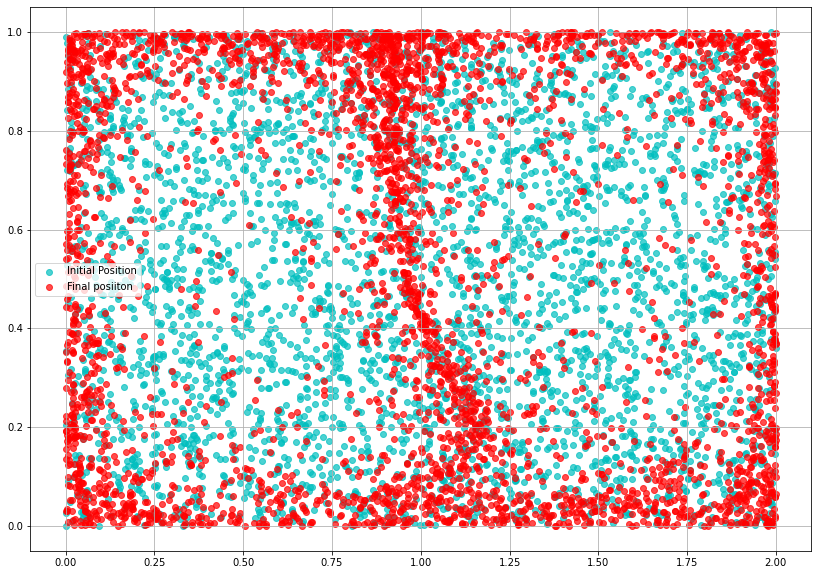

In [2]:
# constants
A = 0.25
epsilon = 0.25
w = np.pi*2 #/10

# horizontal comp.
def f(x,t):
    return epsilon*np.sin(w*t)*(x**2) + (1-2*epsilon*np.sin(w*t))*x

def u_gyre(x,y,t):
    return -np.pi*A*np.sin(np.pi*f(x,t))*np.cos(np.pi*y)

def v_gyre(x,y,t):
    return ((2*epsilon*np.sin(w*t)*x 
            + 1-2*epsilon*np.sin(w*t))*np.sin(np.pi*y)*np.pi*A*np.cos(np.pi*f(x,t)))

# function for random data init 

def rand_trace_double_gyre(M, final_t = 20, no_t_step = 201):

    # generate initial coords
    # draw in interval [0,1] to see it at work
    x0 = np.random.uniform(0,2,M)
    #x0 = (x0 - 0.5)*NX

    y0 = np.random.uniform(0,1,M)
    #y0 = (y0 - 0.5)*NY

    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + u_gyre(x,y,t)*dt
        y1 = y + v_gyre(x,y,t)*dt

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos

# number of data points 
M = 55**2
# M = 23**2
# M = 66**2
M = 60**2

final_time = 10

x_pos, y_pos = rand_trace_double_gyre(M, final_time)
    
# plotting
plt.figure(figsize=(14,10))
plt.scatter(x_pos[0], y_pos[0], color='c', 
            label = 'Initial Position', 
            alpha = 0.7)
plt.scatter(x_pos[-1], y_pos[-1], color='r', 
            label = 'Final posiiton',
            alpha = 0.7)
plt.legend()
plt.grid()
plt.show()

## Loading Trajectories 

In [53]:
# loading and testing 
x_pos = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/x_trajs.npy')
y_pos = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/y_trajs.npy')

# h_result = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/h_fields.npy')
u_result = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/u_fields.npy')
# v_result = np.load('./ShallowWater/eddie_results_store/eddie_files_result4/v_fields.npy')

print(x_pos.shape, u_result.shape)

# omitting some results for speed
skip = 1

x_pos = np.copy(x_pos[::skip, :, :])
y_pos = np.copy(y_pos[::skip, :, :])

(24000, 64, 64) (24000, 64, 64)


In [51]:
x_pos.shape

(24000, 64, 64)

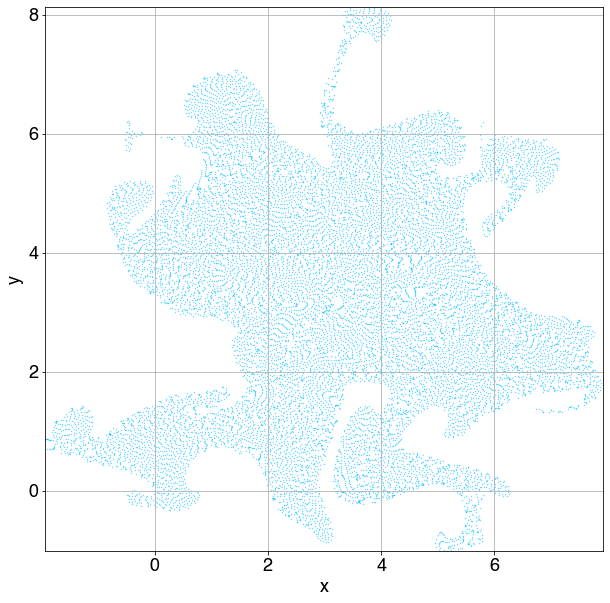

In [49]:
# for lower res
point_size = .125
    
# plotting
plt.figure(figsize=(10,10))
plt.scatter(x_pos[-1], y_pos[-1], color='deepskyblue', 
            label = 'Initial Position', 
            alpha = 0.75, s=point_size)
# plt.scatter(x_pos[-1], y_pos[-1], color='r', 
#             label = 'Final posiiton',
#             alpha = 0.7, s=point_size)

plt.xlim((np.min(x_pos), np.max(x_pos)))
plt.ylim((np.min(y_pos), np.max(y_pos)))

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [9]:
# np.save('result4_x_pos_every20', x_pos)
# np.save('result4_y_pos_every20', y_pos)

## Turb - fast waves

(128, 128)
(128, 128, 601)


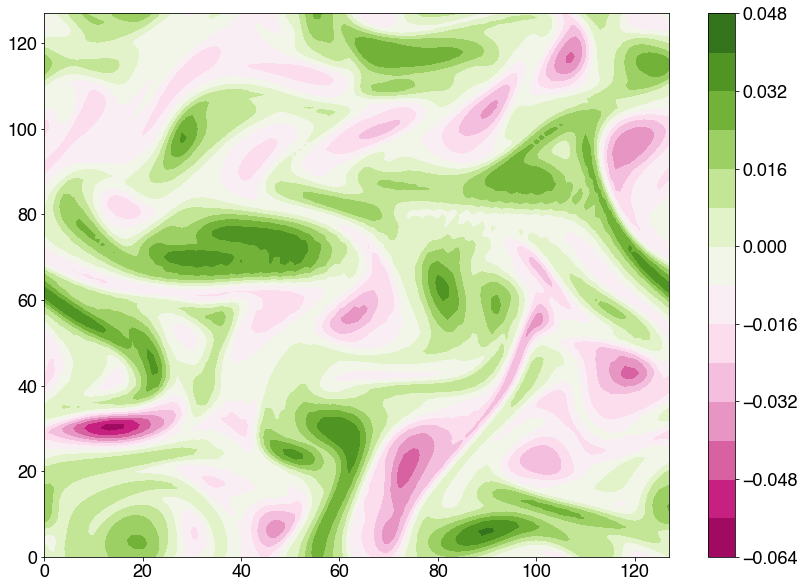

In [34]:
uvSW = loadmat('uv_SWturb_ki2_final_bigwave.mat')
uvSW = loadmat('uv_SWturb_ki2_nowaves.mat')
uu = uvSW['u_all']
vv = uvSW['v_all']

# Time step
Tend = 240

# Note: kw = 7 (wave number)

Nx = 128
Ny = 128
dx = 2*np.pi/Nx
dy = 2*np.pi/Ny
# iTime = 600

iTime = uu.shape[-1] - 1

u_S = np.concatenate((uu[-1:Ny, :, iTime], uu[0:-1, :, iTime]), axis=0)
u_N = np.concatenate((uu[1:, :, iTime], uu[0:1, :, iTime]), axis=0)
v_W = np.concatenate((vv[:, -1:Nx, iTime], vv[:, 0:-1, iTime]), axis=1)
v_E = np.concatenate((vv[:, 1:, iTime], vv[:, 0:1, iTime]), axis=1)

zr = (v_E-v_W)/(2*dy)-(u_N-u_S)/(2*dy)

print(np.shape(u_S))
print(np.shape(uu))

cmap = plt.get_cmap('PiYG')
levels = MaxNLocator(nbins=15).tick_values(zr.min(), zr.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize = (14,10))
ax = plt.axes()
# im = ax.pcolormesh(zr, cmap=cmap, norm=norm)
cf = ax.contourf(zr, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)

plt.show()

(128, 128)
(128, 128, 801)


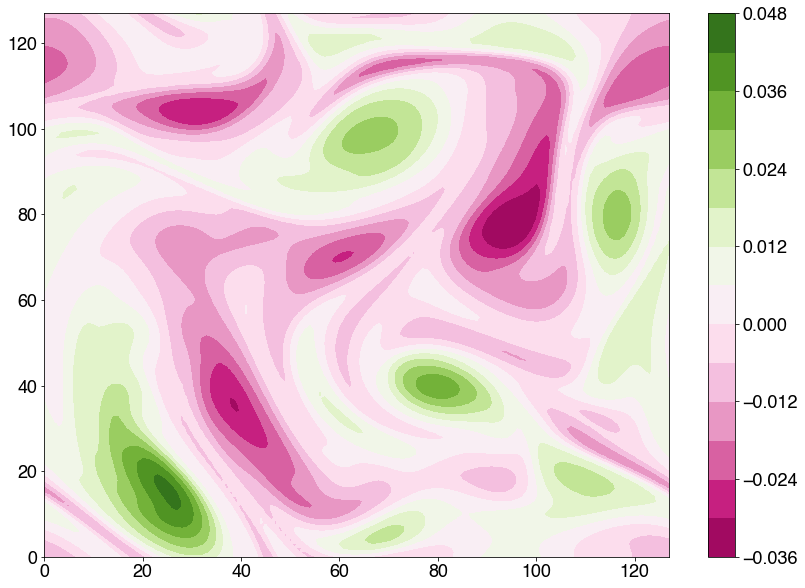

In [3]:
uvSW = loadmat('uv_SWturb_ki2_final_nowave.mat')
uu = uvSW['u_all']
vv = uvSW['v_all']

# Time step
Tend = 160

# Note: kw = 7 (wave number)

Nx = 128
Ny = 128
dx = 2*np.pi/Nx
dy = 2*np.pi/Ny
# iTime = 600

iTime = uu.shape[-1] - 1

u_S = np.concatenate((uu[-1:Ny, :, iTime], uu[0:-1, :, iTime]), axis=0)
u_N = np.concatenate((uu[1:, :, iTime], uu[0:1, :, iTime]), axis=0)
v_W = np.concatenate((vv[:, -1:Nx, iTime], vv[:, 0:-1, iTime]), axis=1)
v_E = np.concatenate((vv[:, 1:, iTime], vv[:, 0:1, iTime]), axis=1)

zr = (v_E-v_W)/(2*dy)-(u_N-u_S)/(2*dy)

print(np.shape(u_S))
print(np.shape(uu))

cmap = plt.get_cmap('PiYG')
levels = MaxNLocator(nbins=15).tick_values(zr.min(), zr.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize = (14,10))
ax = plt.axes()
# im = ax.pcolormesh(zr, cmap=cmap, norm=norm)
cf = ax.contourf(zr, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)

plt.show()

(128, 128)
(128, 128, 801)


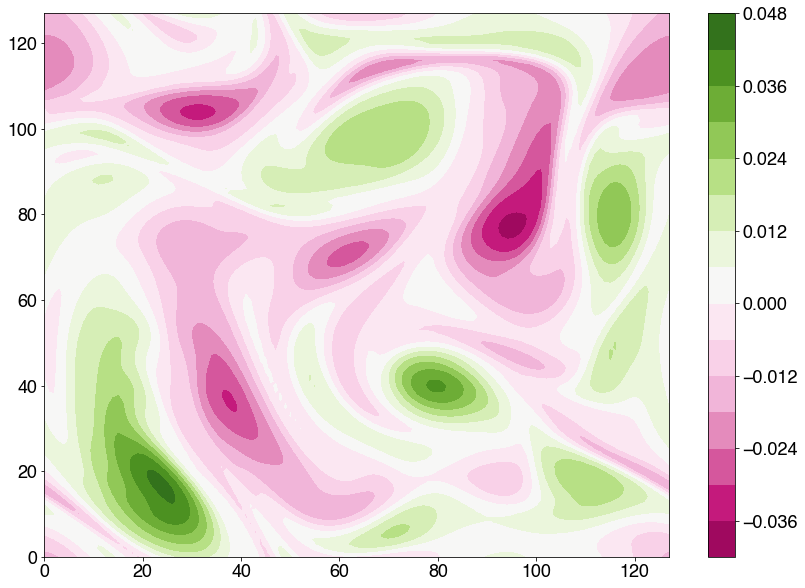

In [21]:
uvSW = loadmat('uv_SWturb_ki2_final_smallwave.mat')
uu = uvSW['u_all']
vv = uvSW['v_all']

# Time step
Tend = 240

# Note: kw = 7 (wave number)

Nx = 128
Ny = 128
dx = 2*np.pi/Nx
dy = 2*np.pi/Ny
# iTime = 600

iTime = uu.shape[-1] - 1

u_S = np.concatenate((uu[-1:Ny, :, iTime], uu[0:-1, :, iTime]), axis=0)
u_N = np.concatenate((uu[1:, :, iTime], uu[0:1, :, iTime]), axis=0)
v_W = np.concatenate((vv[:, -1:Nx, iTime], vv[:, 0:-1, iTime]), axis=1)
v_E = np.concatenate((vv[:, 1:, iTime], vv[:, 0:1, iTime]), axis=1)

zr = (v_E-v_W)/(2*dy)-(u_N-u_S)/(2*dy)

print(np.shape(u_S))
print(np.shape(uu))

cmap = plt.get_cmap('PiYG')
levels = MaxNLocator(nbins=15).tick_values(zr.min(), zr.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize = (14,10))
ax = plt.axes()
# im = ax.pcolormesh(zr, cmap=cmap, norm=norm)
cf = ax.contourf(zr, levels=levels, cmap=cmap)
fig.colorbar(cf, ax=ax)

plt.show()

## Helper Functions

In [35]:
# plotting different liklihood values
def plot_cluster_likelihoods(x, y, u, fig_dim = (12,12)):
    
    #fig, axes = plt.subplots(u.shape[0], 1, sharex=True, figsize=(16,10))
    
    print(f'\nThe likelihood plots for {u.shape[1]} clusters are as follows: \n')
    
    # create bins
    bins = np.linspace(0,1,11)
    
    # loop through each cluster
    for i in range(u.shape[1]):
        
        # extract cluster likelihood
        cluster_u = u[:,i]
        
        # bin u values
        u_binned = np.digitize(cluster_u, bins)

        # plotting
        plt.figure(figsize=fig_dim)

        sns.scatterplot(x=x_dat,
                        y=y_dat,
                        hue=u_binned,
                        palette='plasma',
                        alpha=0.7,
                        legend='full')

        plt.title(f'Cluster {i+1} membership likelihood values')
        plt.legend(np.round(bins[1:],1), title='Likelihood Value')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.tight_layout()
    plt.show()
    
    print('-------------------------------------------------------------------------------------------------\n')
    
def bilinear_interp_periodic(x_1d, y_1d, zz, x_wanted, y_wanted):
    '''
    Hossein's interpolation function:
    x_1d, y_1d (1darray): row and columns respectively of regularly spaced grid - each is a 1d array
    zz (2d array): values to be interpolated
    x_wanted, y_wanted: array of particle positions we want to interpolate
    '''
    init_shape = shape(x_wanted)
    x_wanted = x_wanted.flatten()
    y_wanted = y_wanted.flatten()
    z_wanted = np.zeros_like(x_wanted)

#     x_max = np.max(x_1d)
#     x_min = np.min(x_1d)
#     y_max = np.max(y_1d)
#     y_min = np.min(y_1d)

#     x_interval = x_max - x_min
#     y_interval = y_max - y_min

    for i_xy in range(0, size(x_wanted)):
        x = x_wanted[i_xy]
        y = y_wanted[i_xy]

        # this might be redundant and actually causing errors in the general case?
        # x = x - np.floor(x/x_interval)*(x_interval)
        # y = y - np.floor(y/(y_interval))*(y_interval)

#         i_2x = searchsorted(x_1d, x)
#         i_2y = searchsorted(y_1d, y)

        i_2x = bisect_right(x_1d, x)
        i_2y = bisect_right(y_1d, y)
        i_1x = i_2x - 1
        i_1y = i_2y - 1
        
        #print(i_2x, i_2y)

        FF = array([[zz[i_1y, i_1x], zz[i_2y, i_1x]],
                       [zz[i_1y, i_2x], zz[i_2y, i_2x]]])
        z_wanted[i_xy] = 1/((x_1d[i_2x]-x_1d[i_1x])*(y_1d[i_2y]-y_1d[i_1y]))*(
            array([x_1d[i_2x] - x, x - x_1d[i_1x]])@FF@
            array([[y_1d[i_2y] - y], [y - y_1d[i_1y]]]))

    return reshape(z_wanted, init_shape)

def domain_check2(x,y, x_grid, y_grid):
    '''
    Function to get particle position in 'original' domain
    faster and assumes that we do not get more than 1 domain length away from the domain in 1 timestep
    '''

    # get max and min values
    x_max = x_grid[-1]
    x_min = x_grid[0]
    y_max = y_grid[-1]
    y_min = y_grid[0]

    # intervals
    x_int = x_max - x_min
    y_int = y_max - y_min

    # get x coords in original domain
    new_x = where(x >= x_max, x - x_int, x)
    new_x = where(new_x < x_min, new_x + x_int, new_x)

    # get y coords in original domain
    new_y = where(y >= y_max, y - y_int, y)
    new_y = where(new_y < y_min, new_y + y_int, new_y)

    return new_x, new_y

## advect particle positions - only for matlab files

In [37]:
Nx = 128
Ny = 128

# define domain boundaries
x_start = 0
x_end = 2*np.pi
y_start = 0
y_end = 2*np.pi

res = 5
no_skip = 2

# timestep
dt = 0.04 * (res*no_skip)

# create x and y spacing
x = np.linspace(0, 2*np.pi, Nx)
y = np.linspace(0, 2*np.pi, Ny)


# create particle grid
x_grid, y_grid = np.meshgrid(x, y)

# copy grid position for initial position
x_pos, y_pos = np.copy(x_grid), np.copy(y_grid)

# add trajectory to list and start list
x_traj = [np.copy(x_pos)]
y_traj = [np.copy(y_pos)]

# loop through each velocity field
for i in range(uu.shape[-1]):
    
    # check all points are in domain
    x_in_domain, y_in_domain = domain_check2(x_pos, y_pos, x, y)
    
    # run twice for redundancy
    x_pos_in_domain_check, y_pos_in_domain_check = domain_check2(x_in_domain, y_in_domain, x, y)
    
    # check that particles are in domain
    while np.all(x_pos_in_domain_check == x_in_domain) != True or np.all(y_pos_in_domain_check == y_in_domain) != True:
        x_pos_in_domain_check, y_pos_in_domain_check = np.copy(x_in_domain), np.copy(y_in_domain)
        x_in_domain, y_in_domain = domain_check2(x_pos_in_domain_check, x_pos_in_domain_check, x, y)
    
    # interpolate velocity values and update x_pos, y_pos
    x_pos += dt*bilinear_interp_periodic(x, y, uu[:,:,i], x_in_domain, y_in_domain)
    y_pos += dt*bilinear_interp_periodic(x, y, vv[:,:,i], x_in_domain, y_in_domain)
    
#     if i % 100 == 0:
#         plt.figure(figsize=(14,10))
#         plt.scatter(x_pos.flatten(), y_pos.flatten(),
#                     alpha = 0.75)
#         plt.grid()
#         plt.show()
    
    x_traj.append(np.copy(x_pos))
    y_traj.append(np.copy(y_pos))

In [16]:
nowave_x_traj = np.copy(x_traj)
nowave_y_traj = np.copy(y_traj)

In [24]:
slowwave_x_traj = np.copy(x_traj)
slowwave_y_traj = np.copy(y_traj)

In [35]:
fastwave_x_traj = np.copy(x_traj)
fastwave_y_traj = np.copy(y_traj)

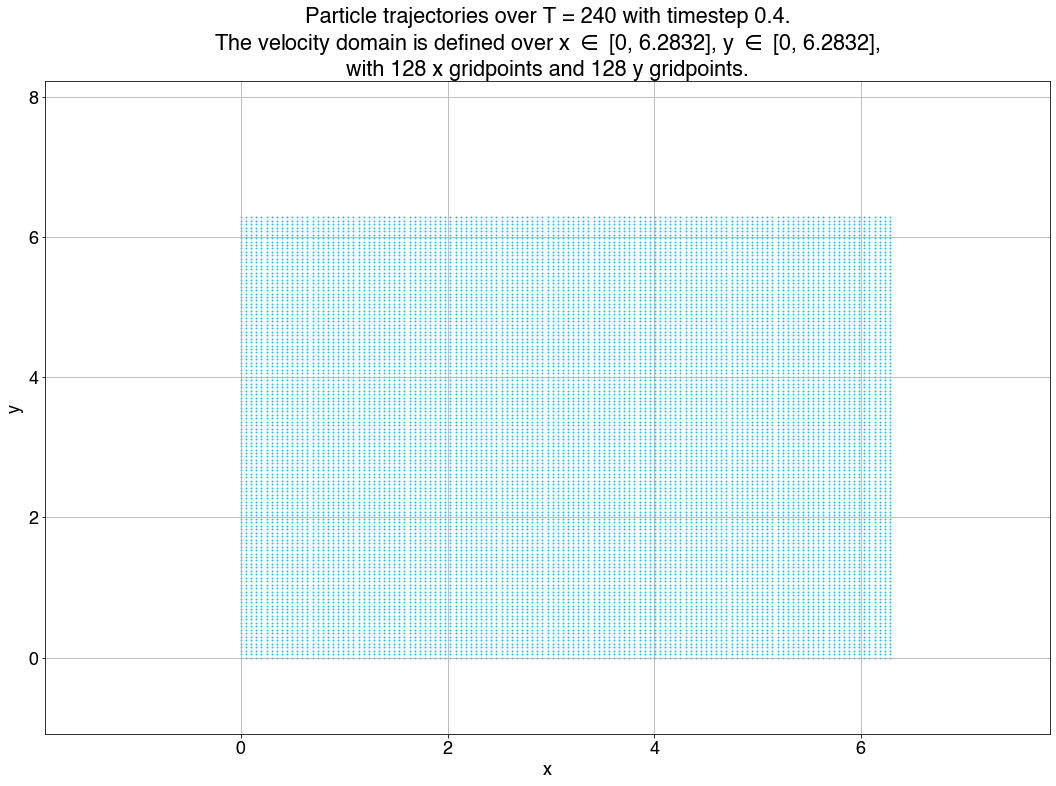

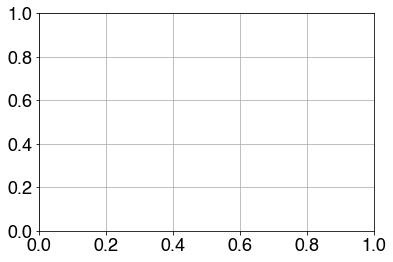

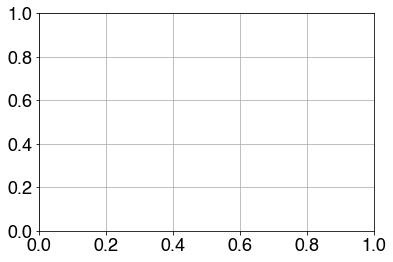

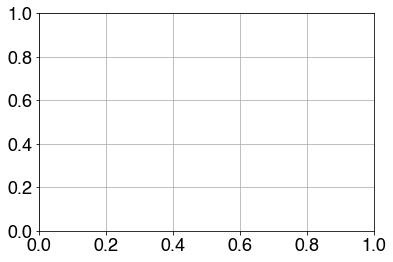

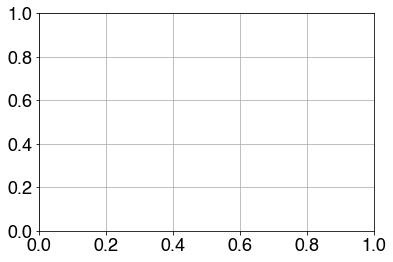

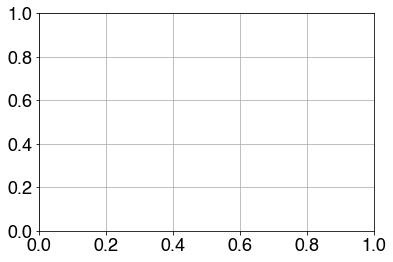

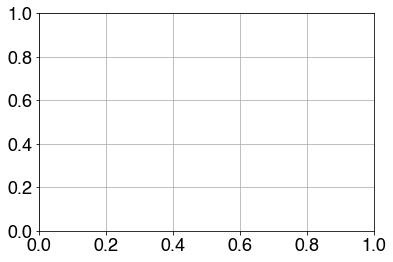

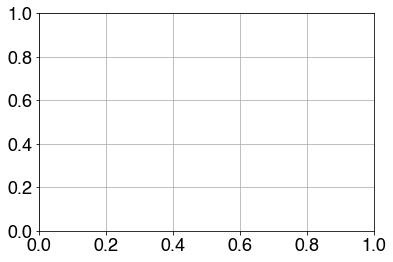

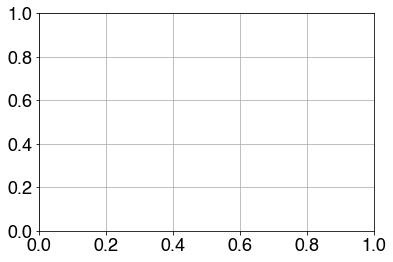

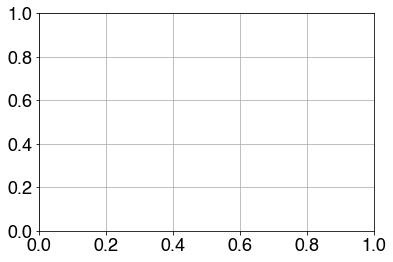

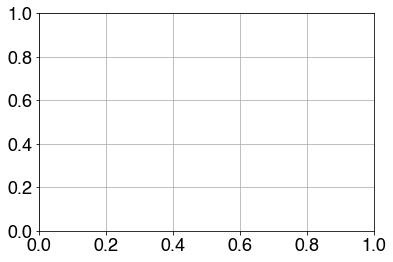

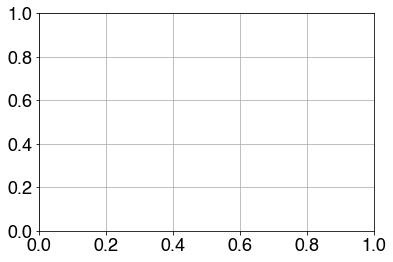

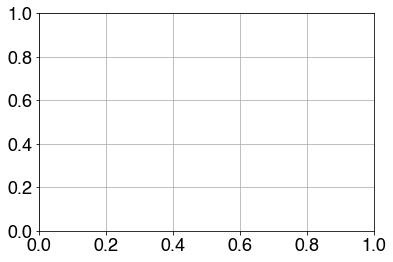

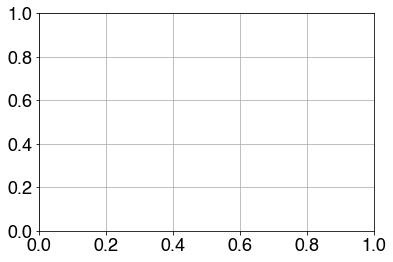

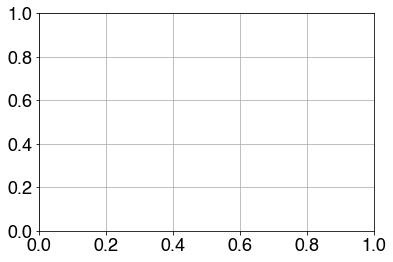

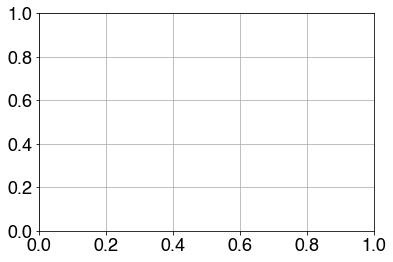

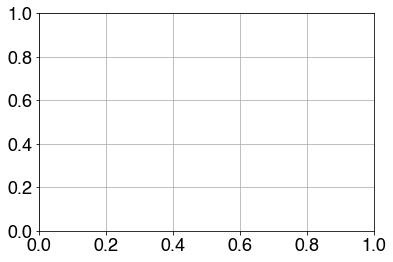

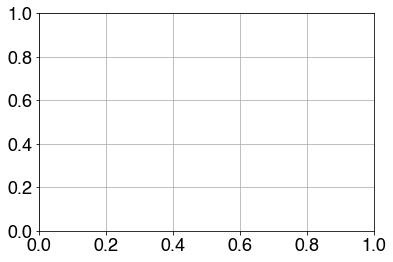

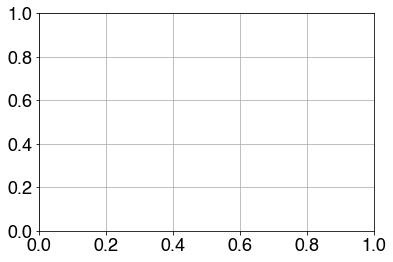

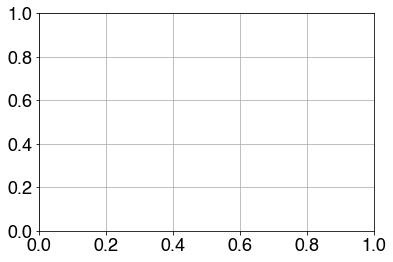

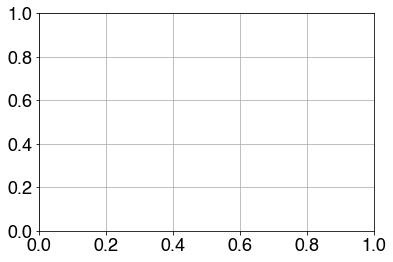

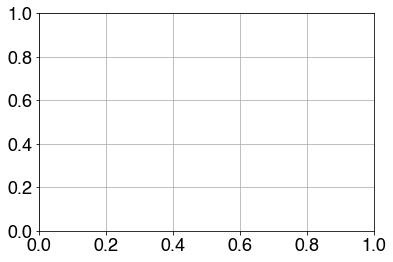

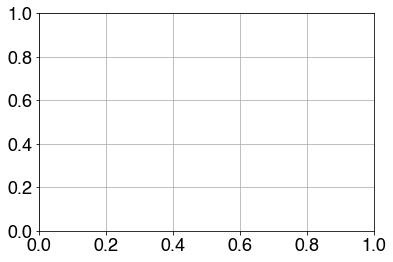

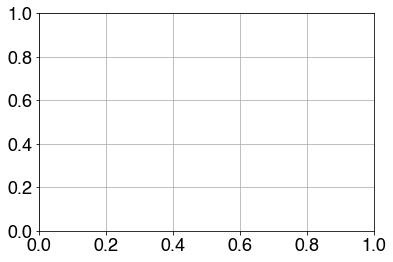

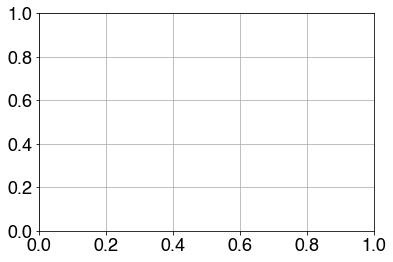

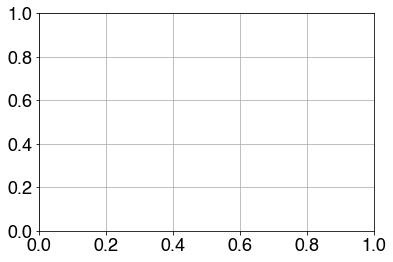

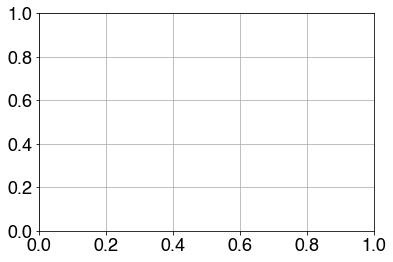

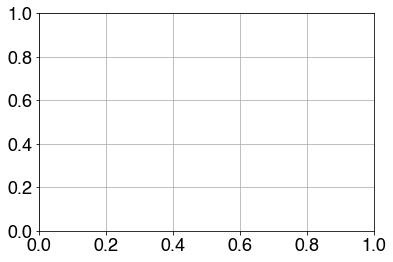

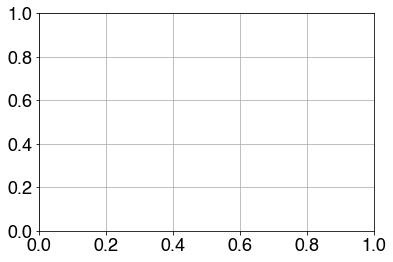

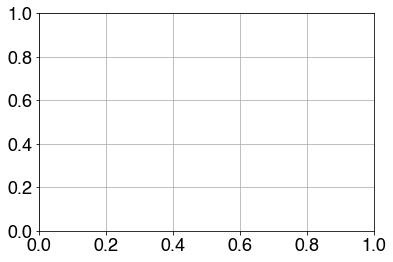

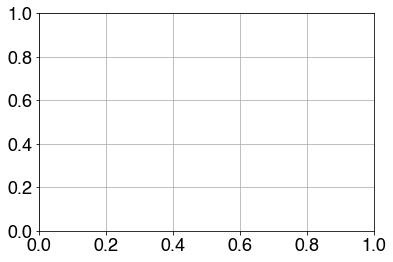

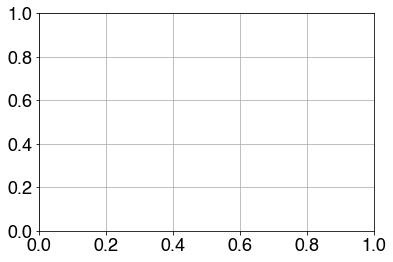

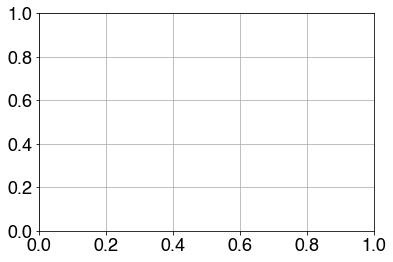

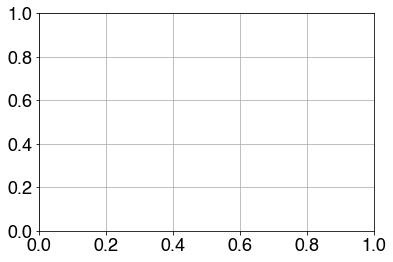

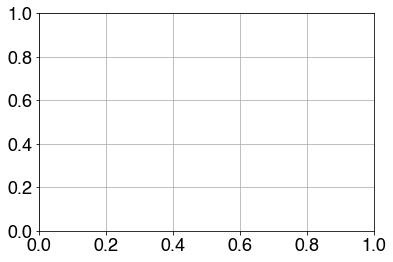

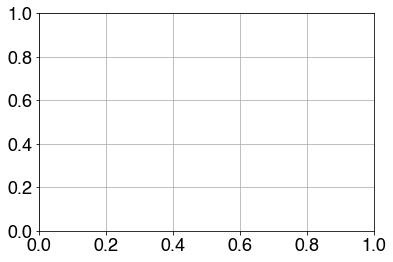

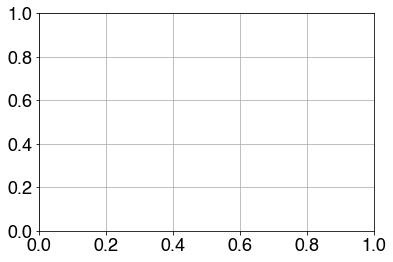

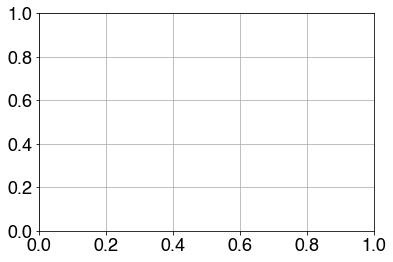

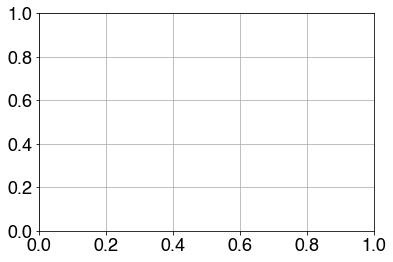

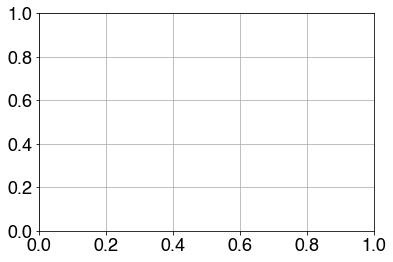

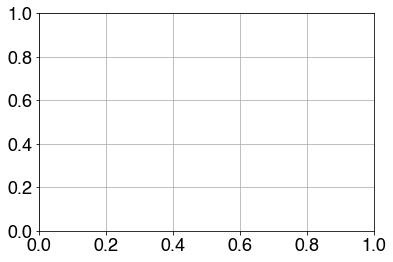

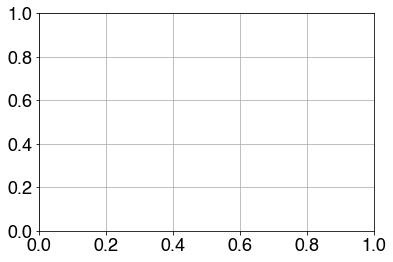

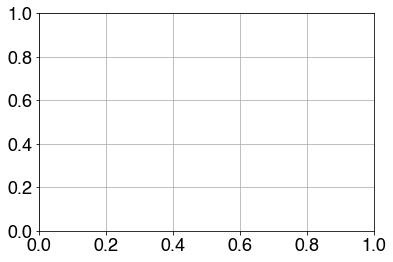

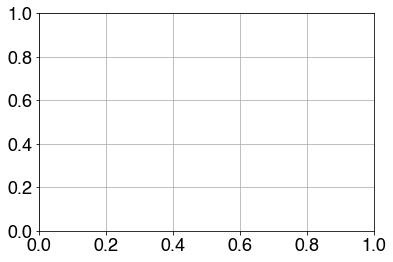

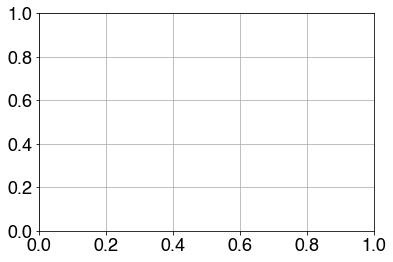

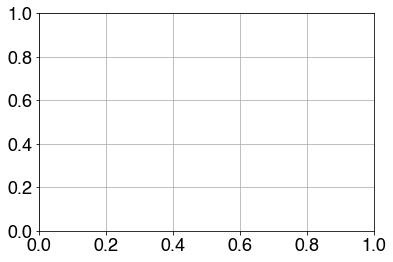

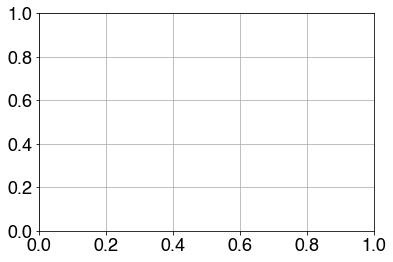

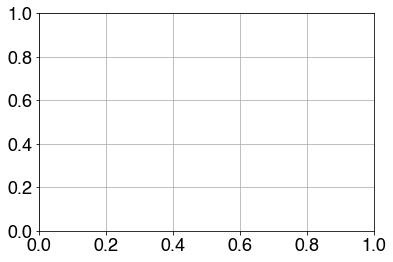

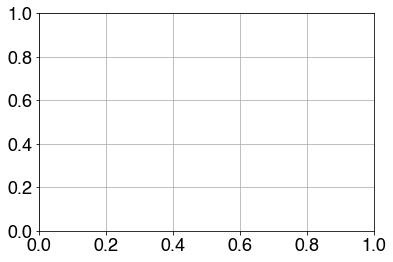

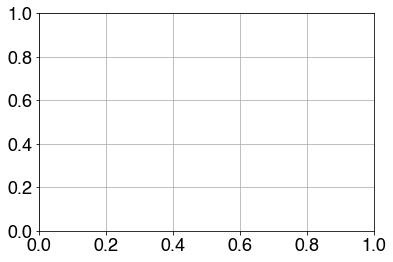

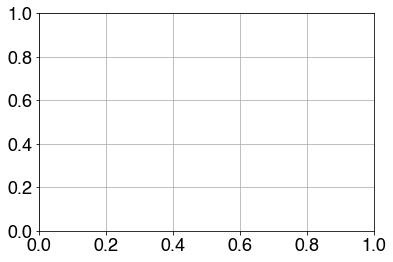

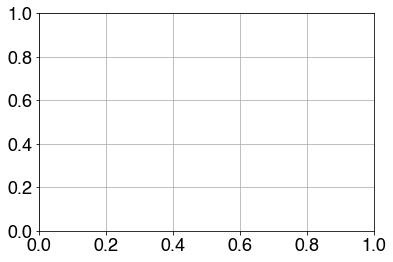

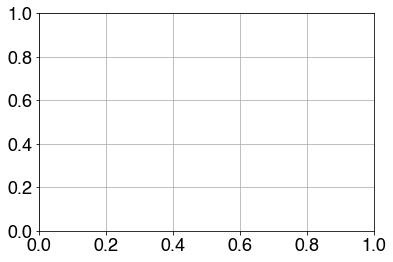

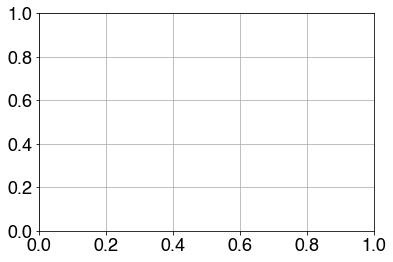

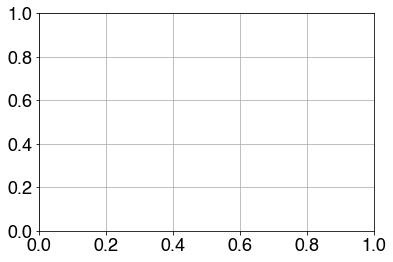

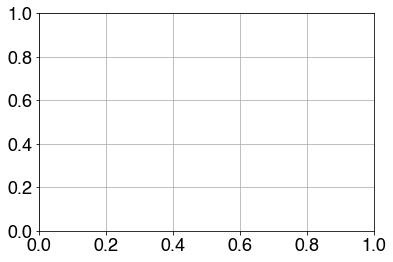

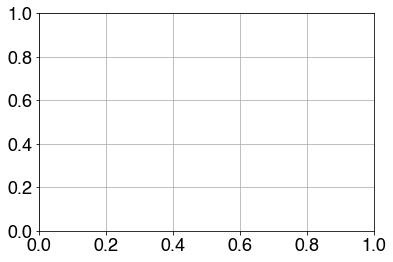

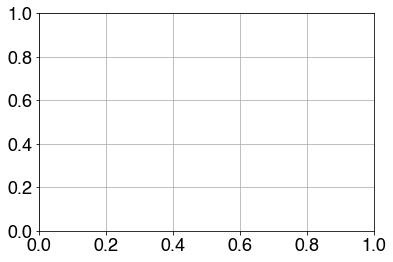

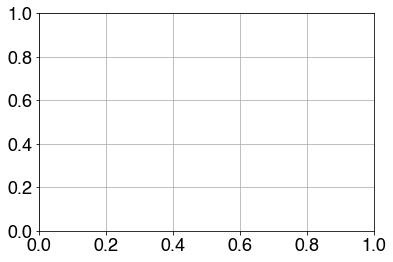

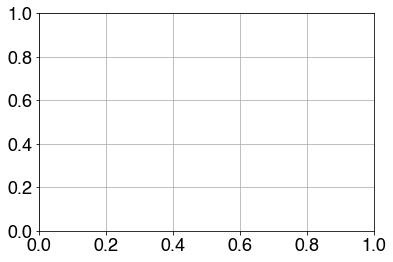

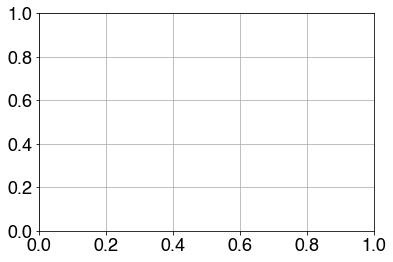

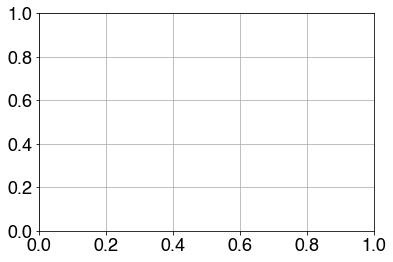

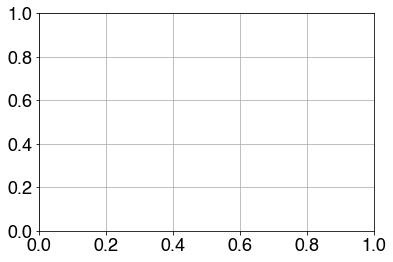

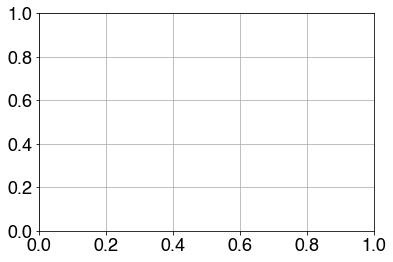

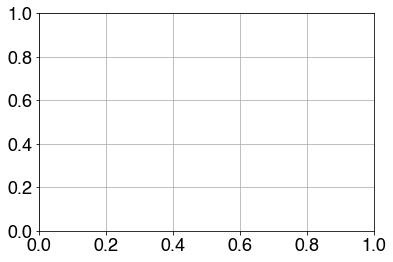

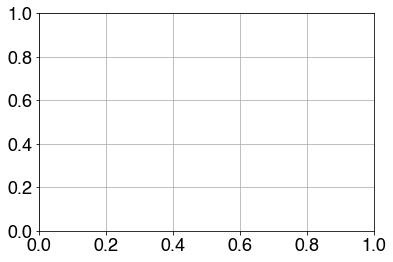

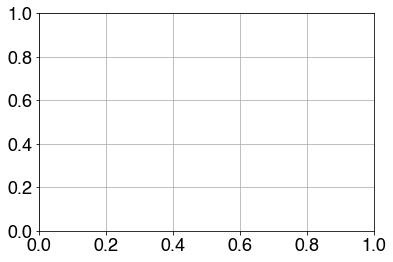

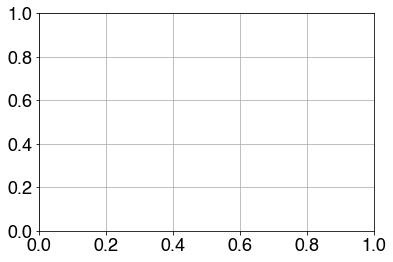

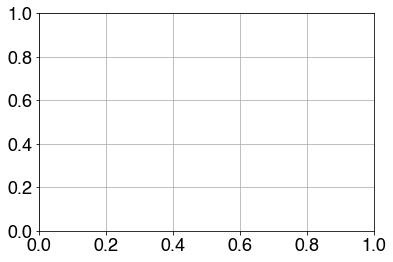

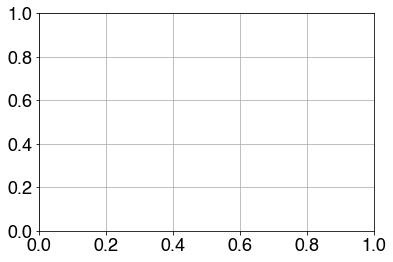

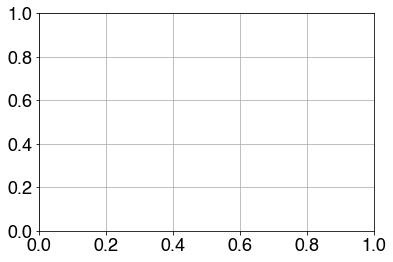

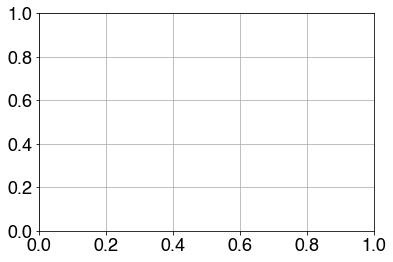

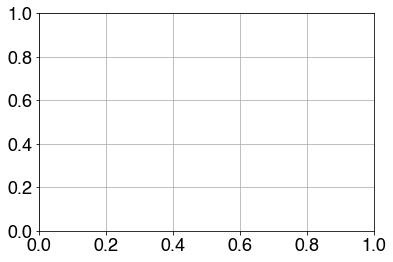

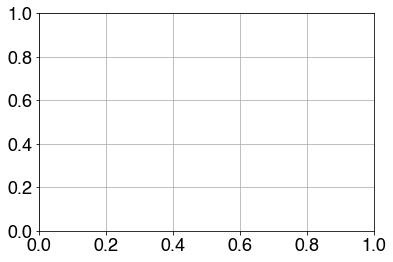

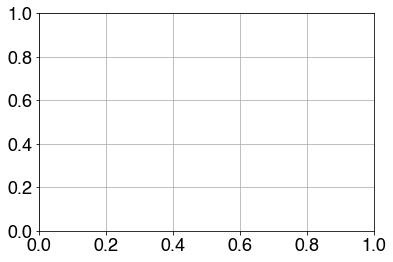

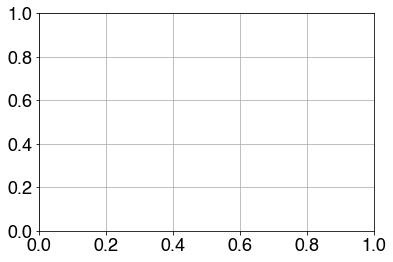

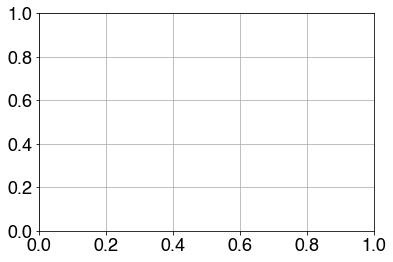

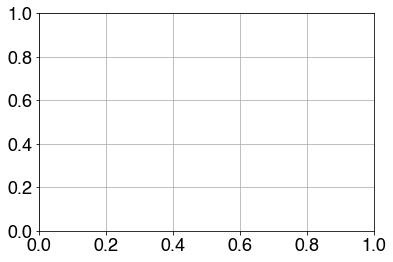

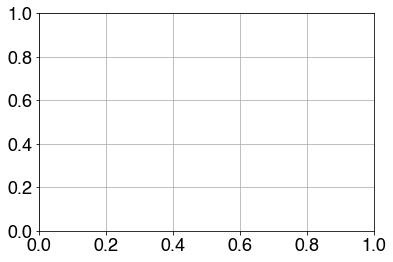

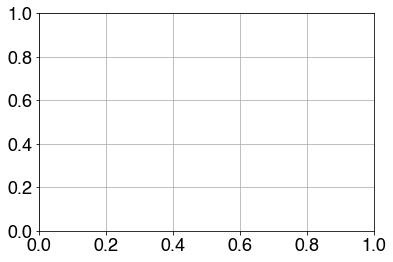

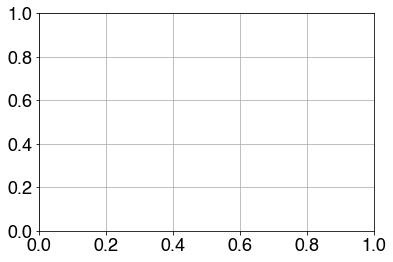

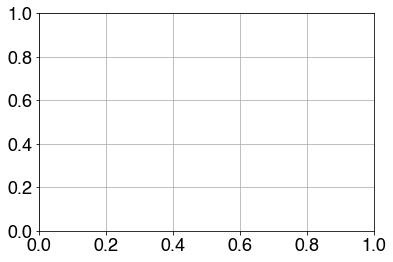

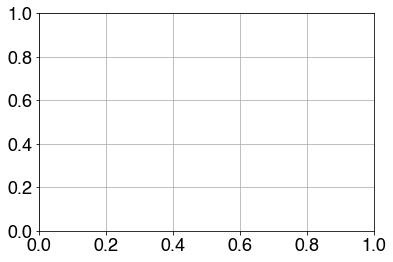

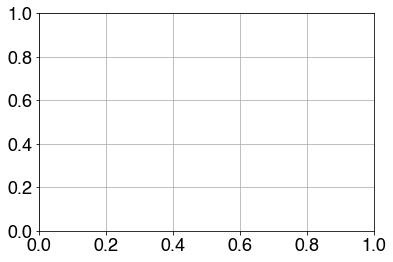

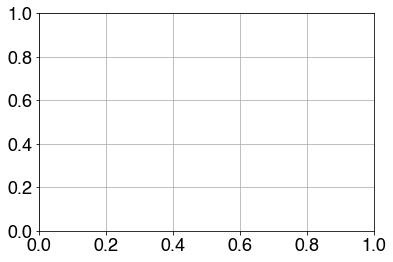

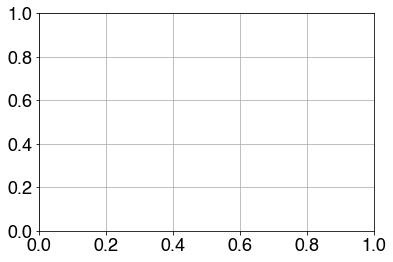

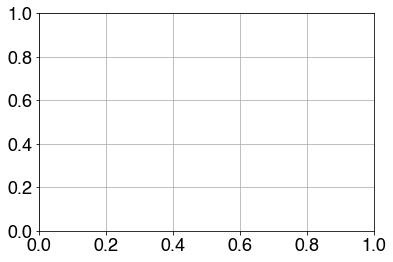

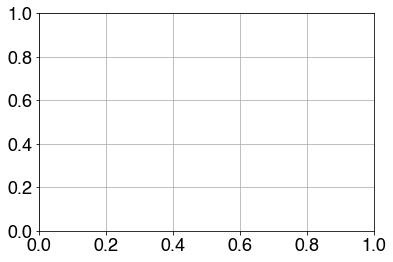

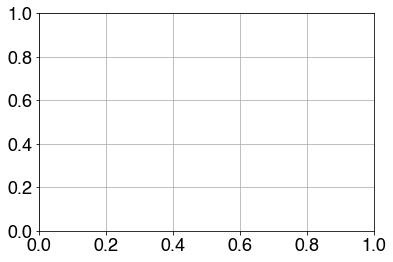

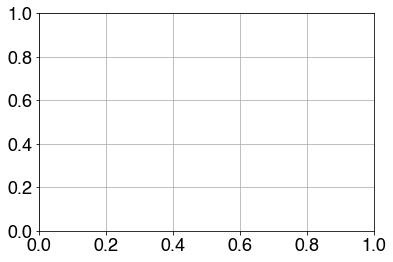

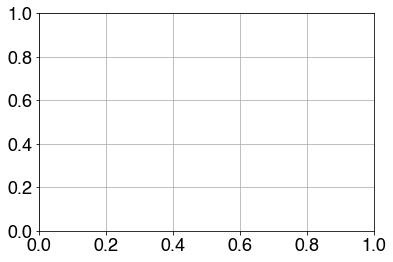

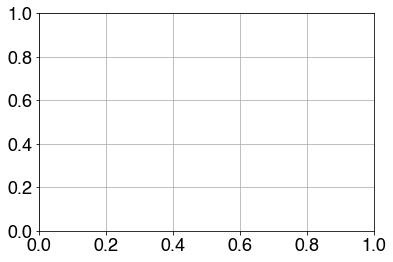

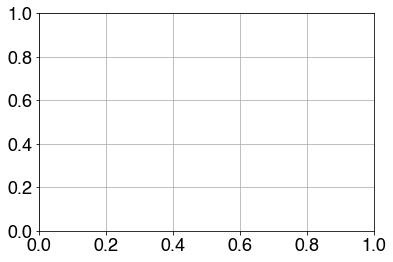

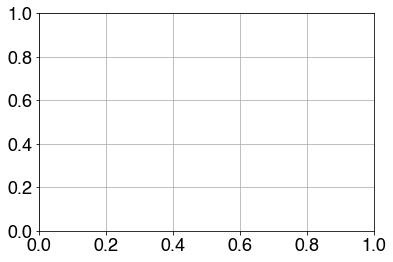

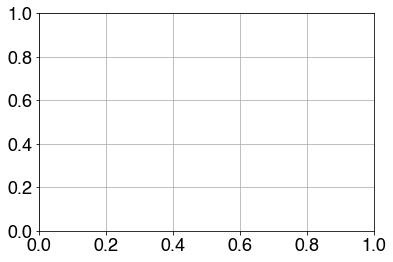

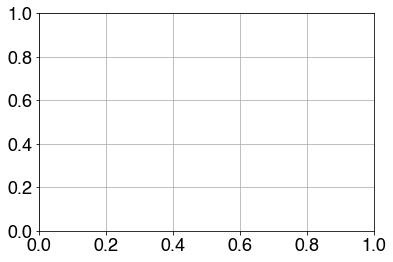

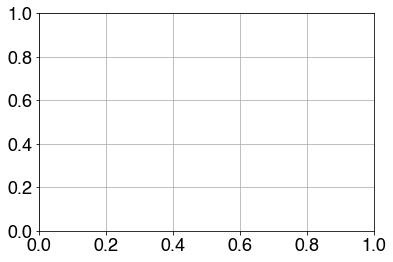

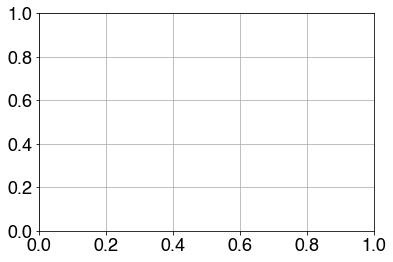

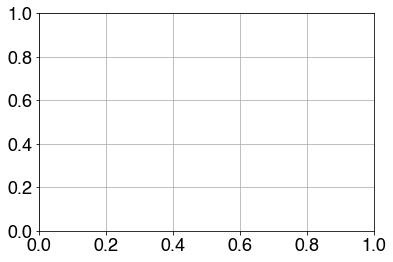

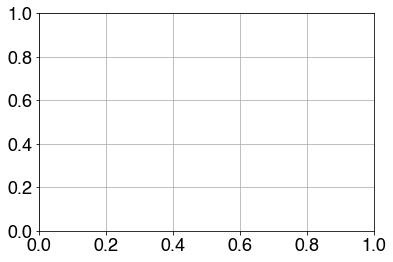

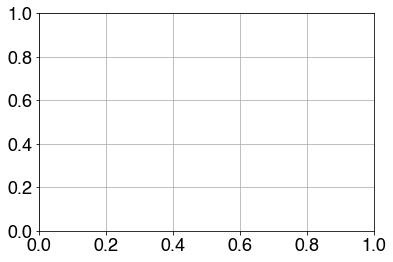

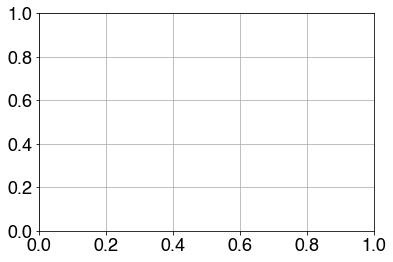

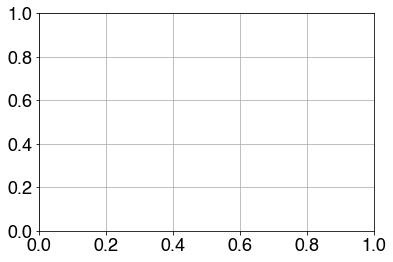

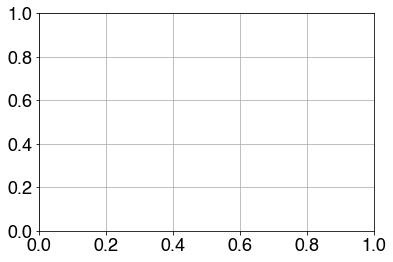

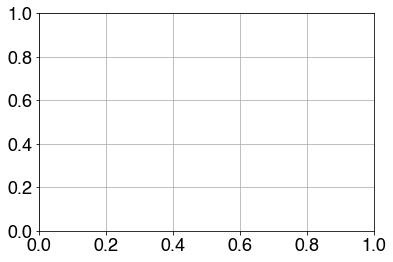

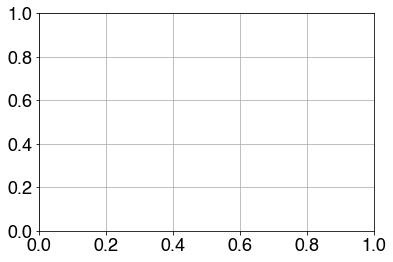

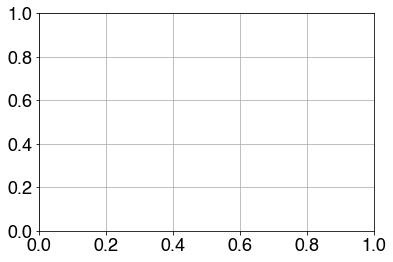

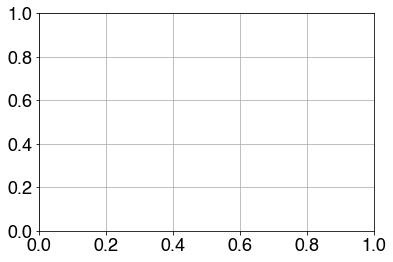

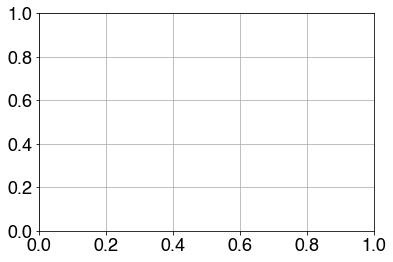

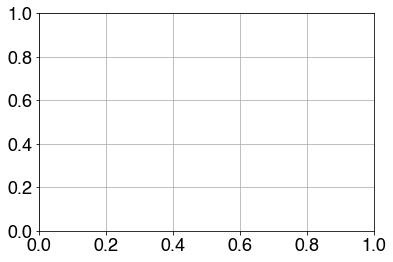

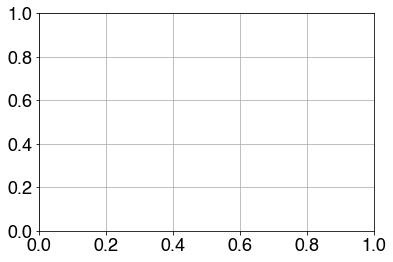

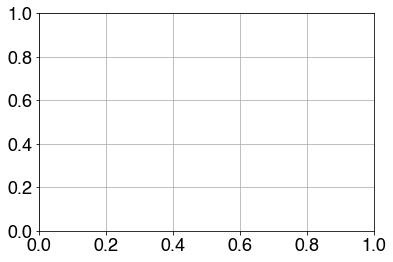

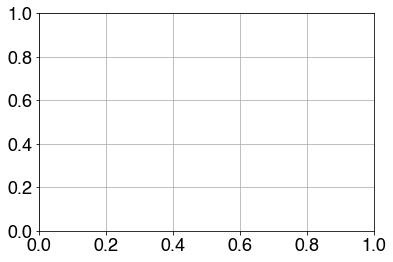

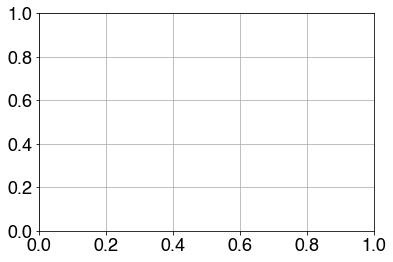

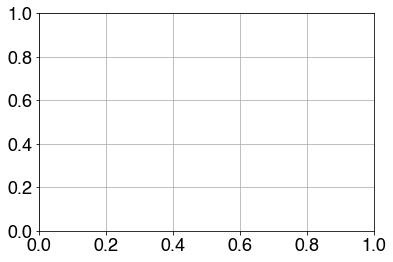

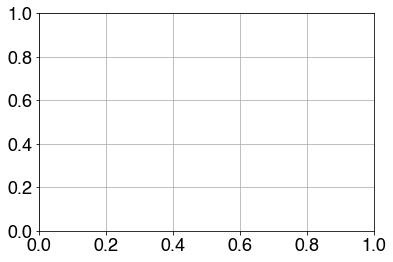

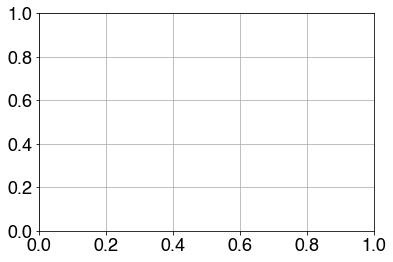

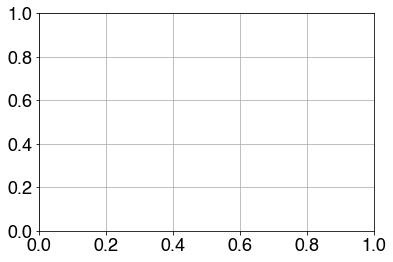

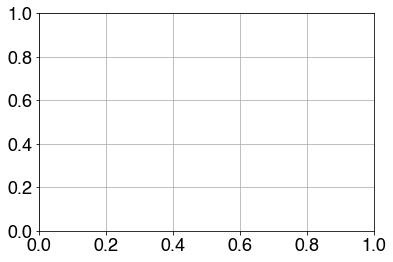

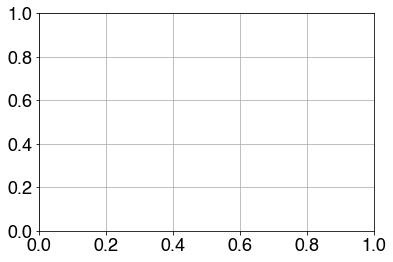

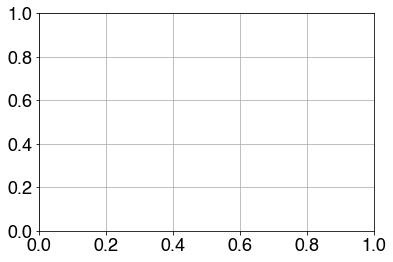

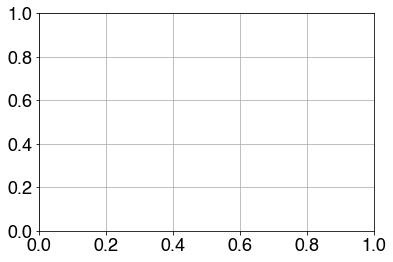

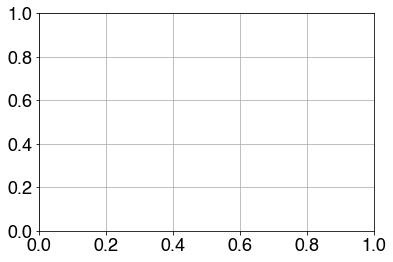

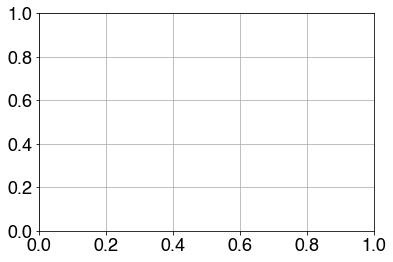

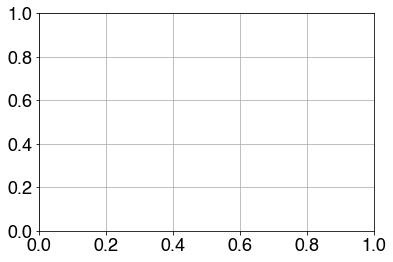

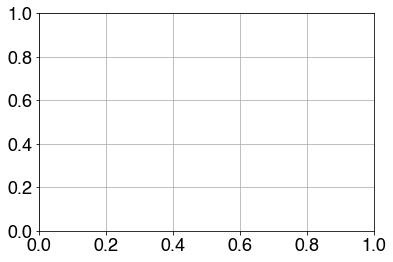

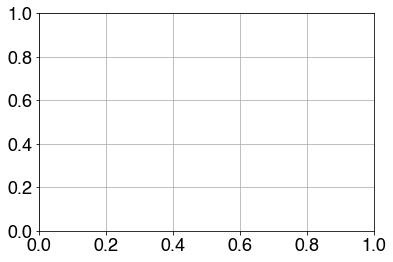

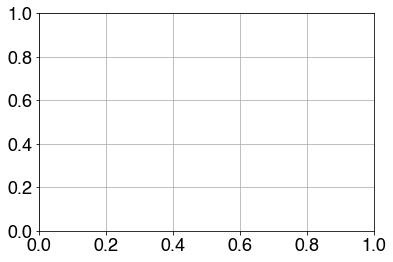

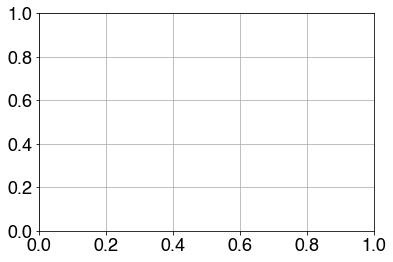

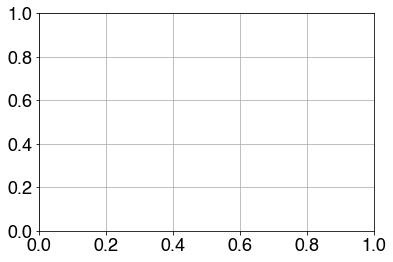

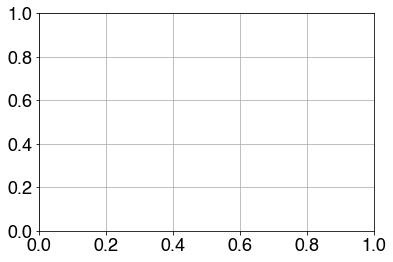

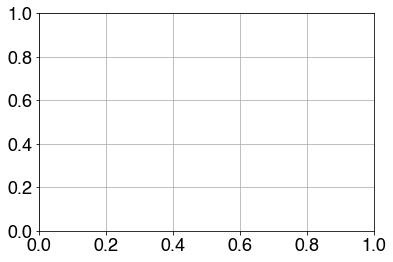

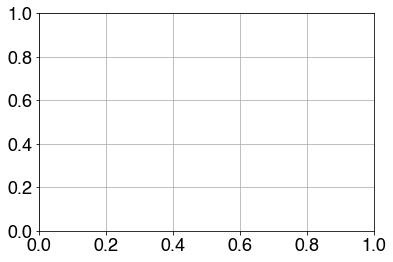

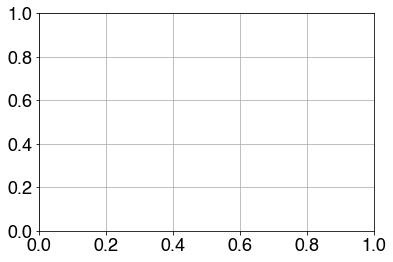

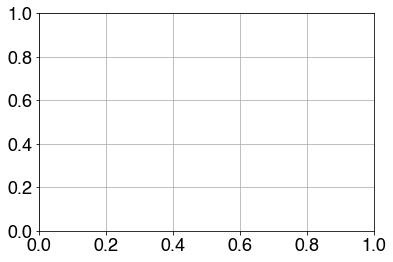

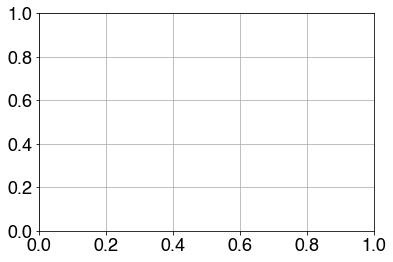

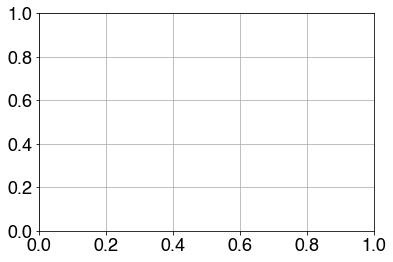

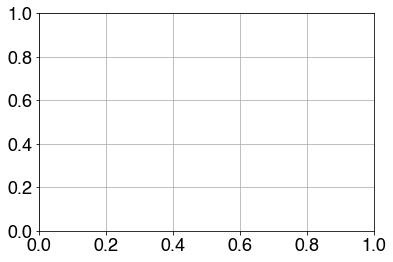

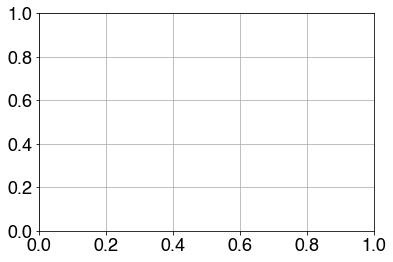

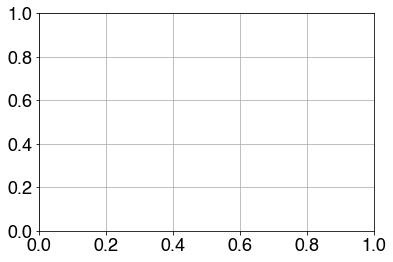

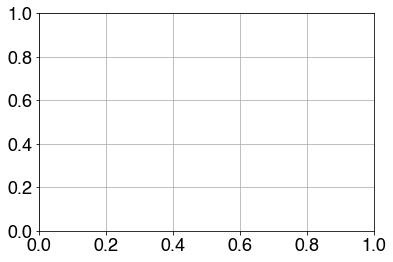

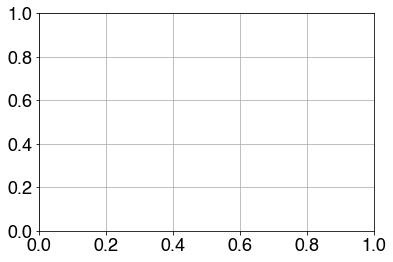

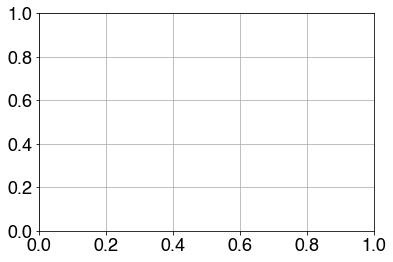

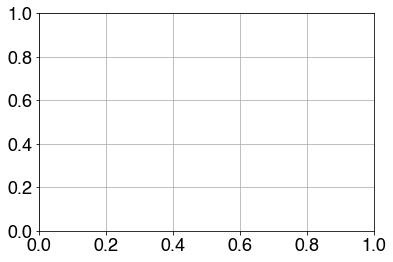

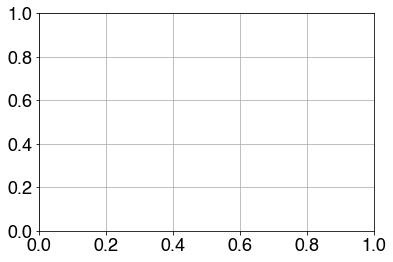

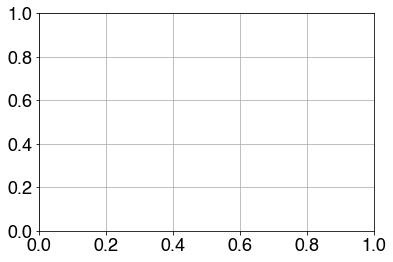

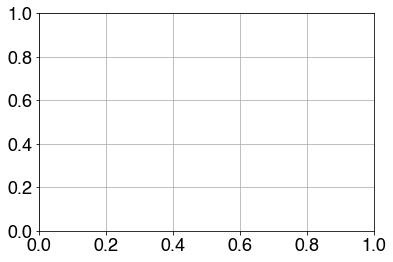

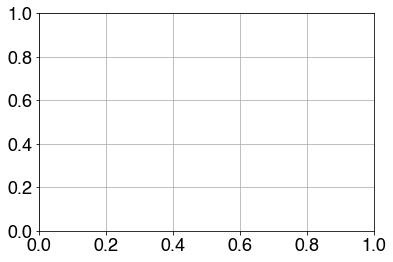

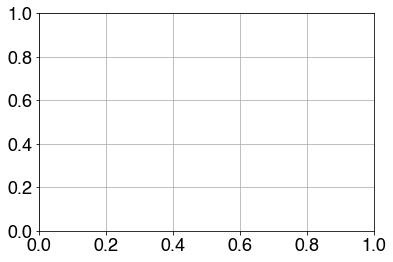

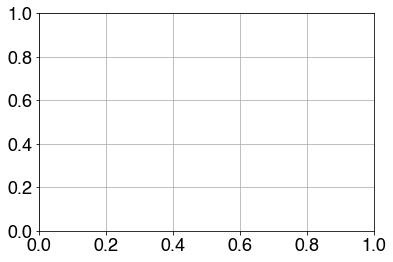

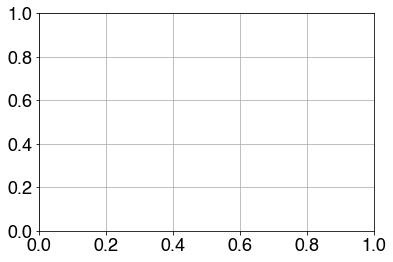

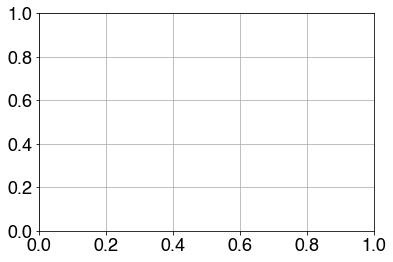

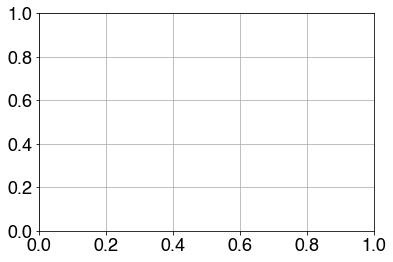

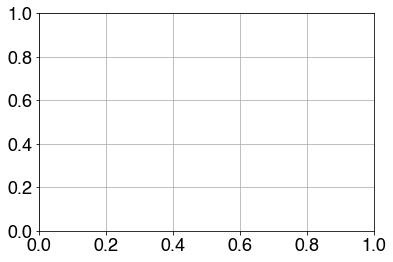

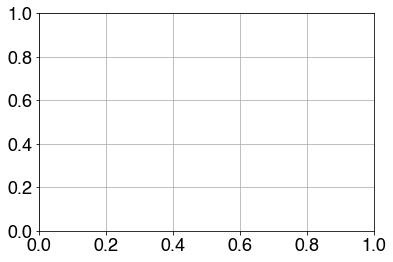

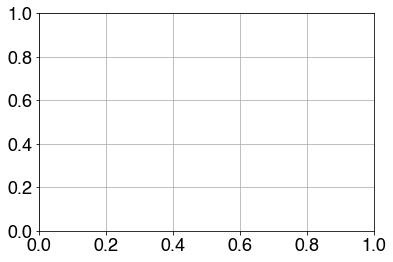

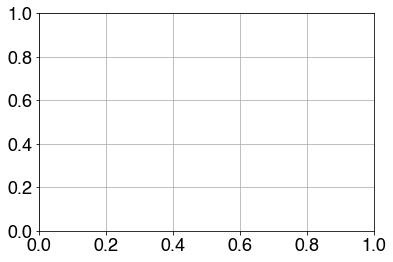

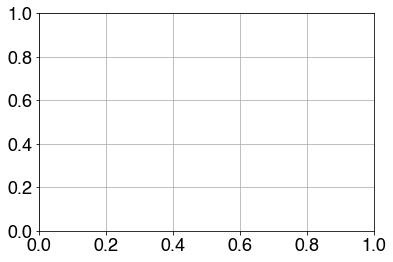

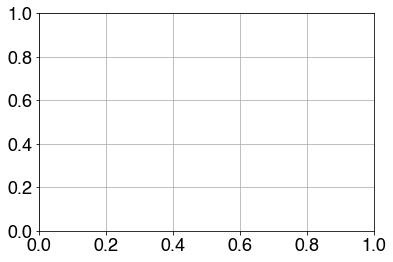

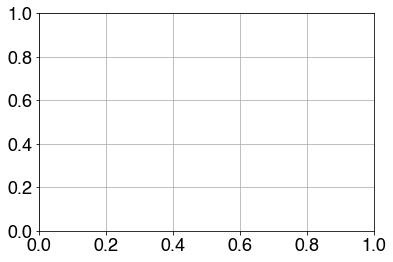

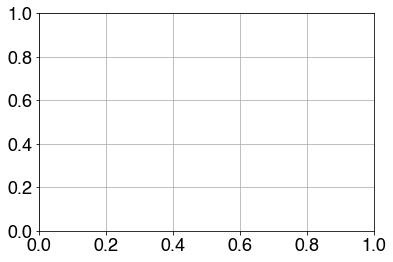

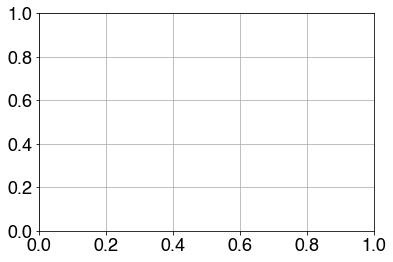

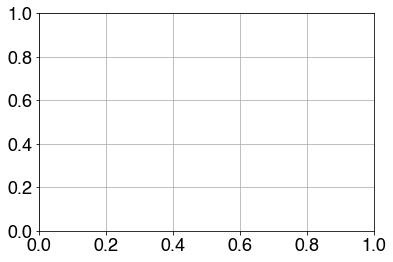

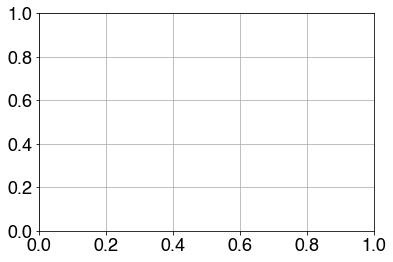

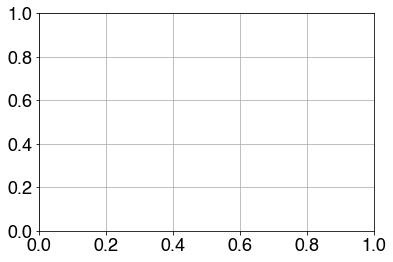

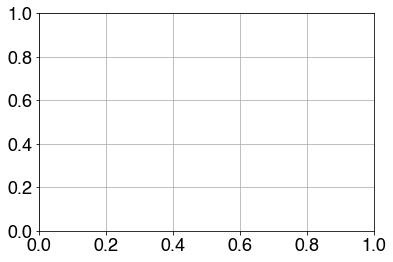

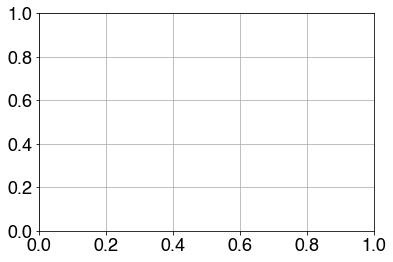

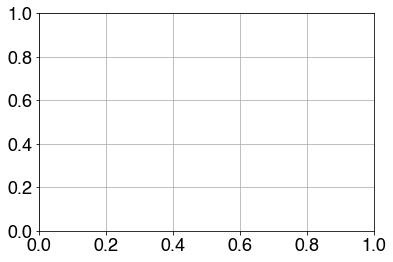

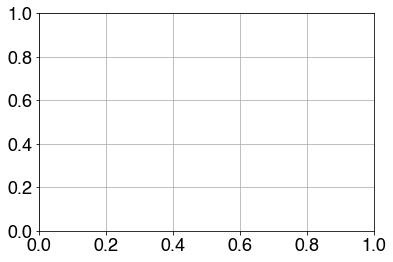

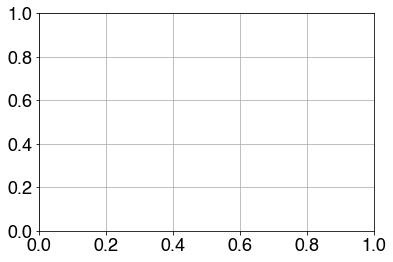

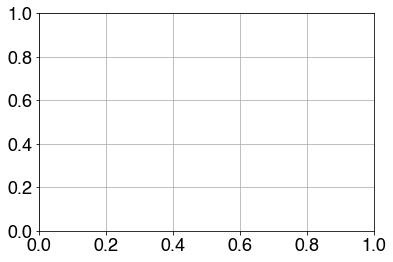

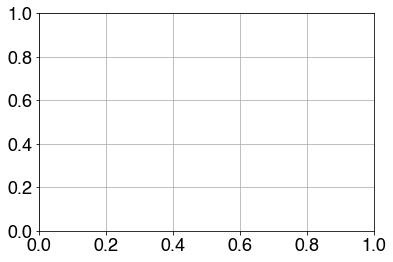

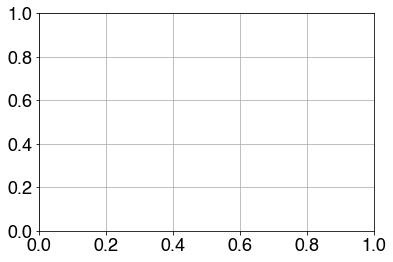

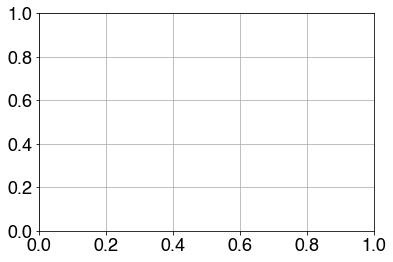

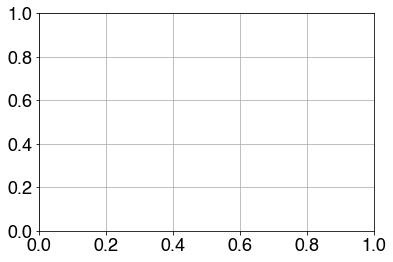

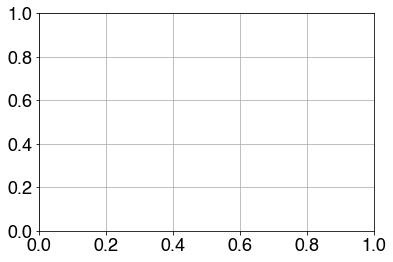

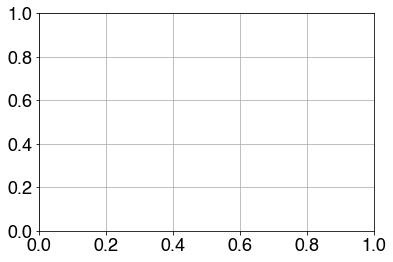

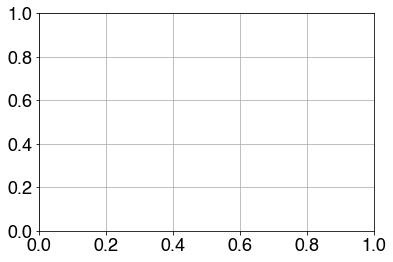

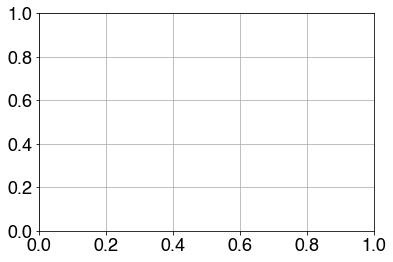

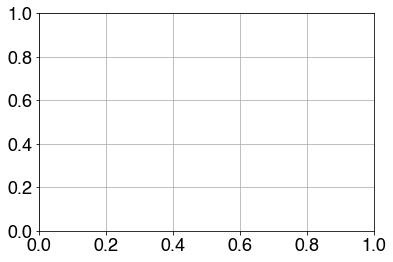

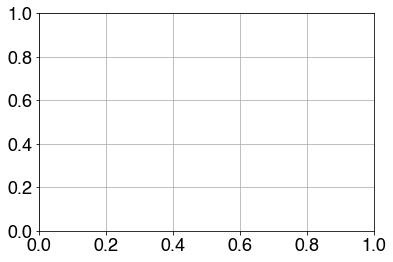

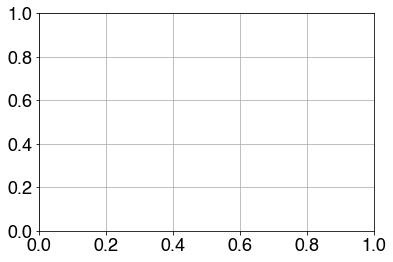

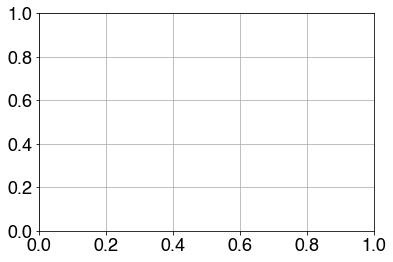

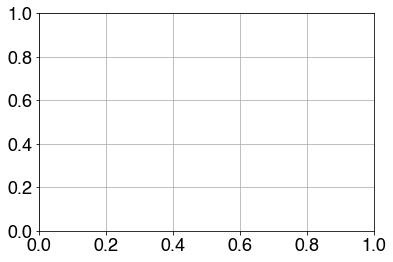

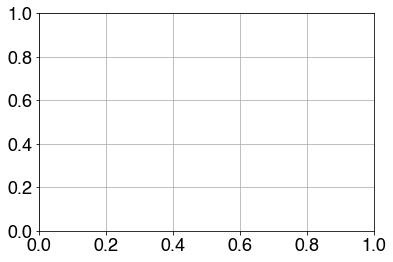

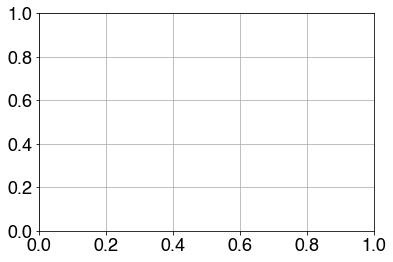

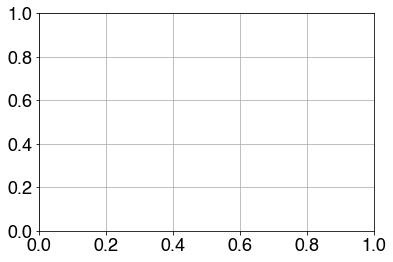

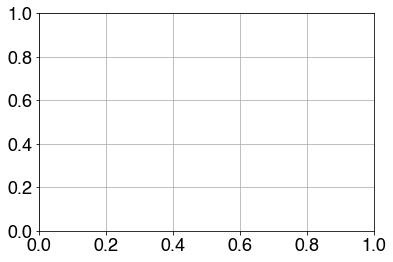

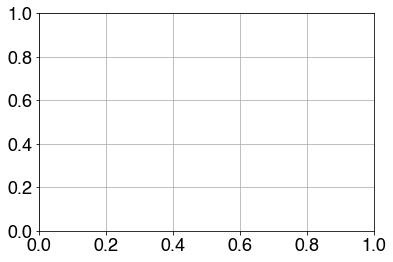

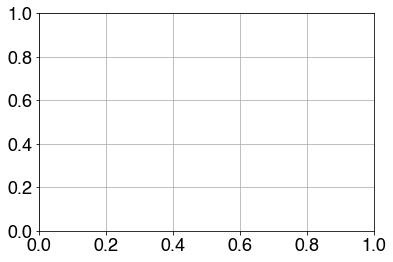

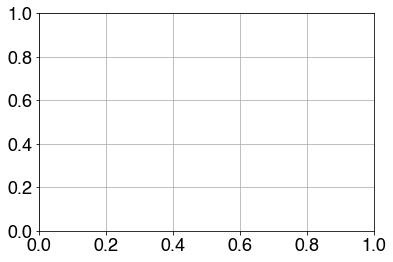

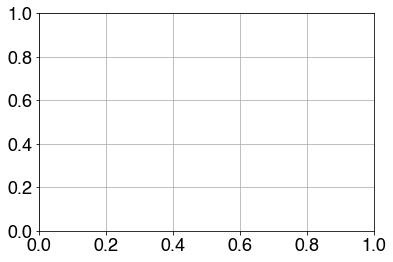

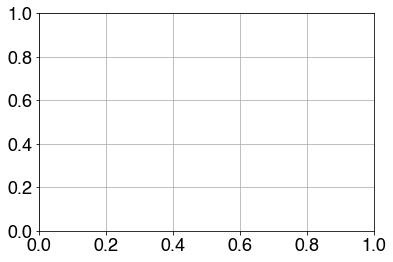

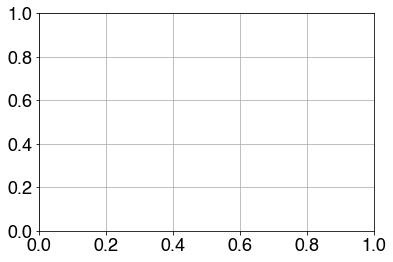

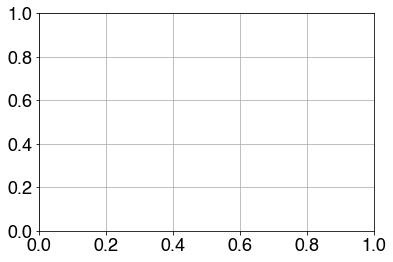

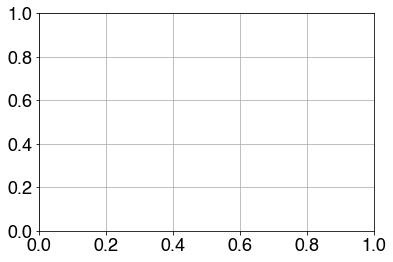

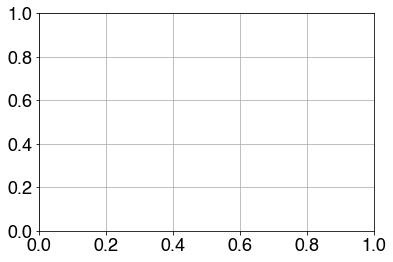

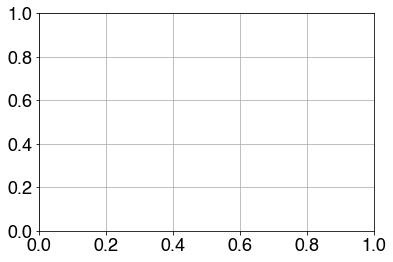

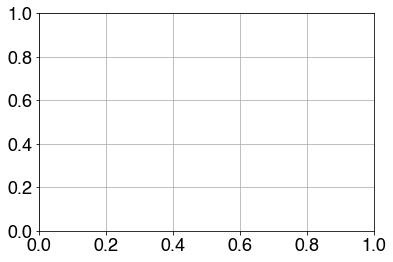

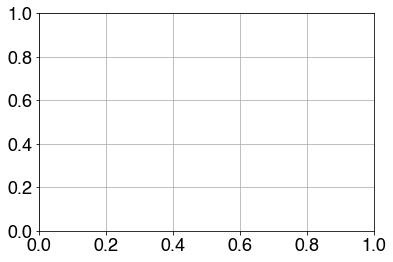

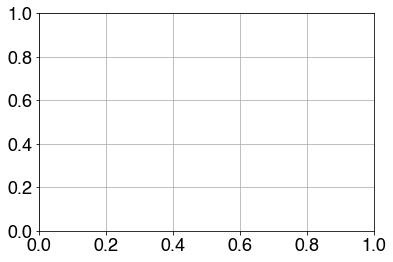

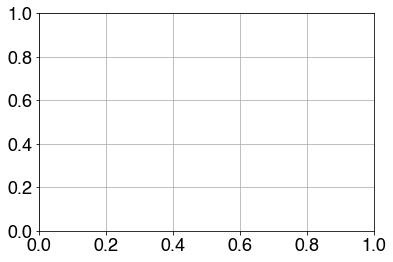

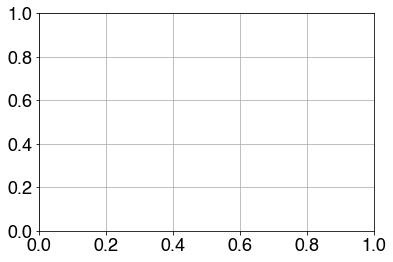

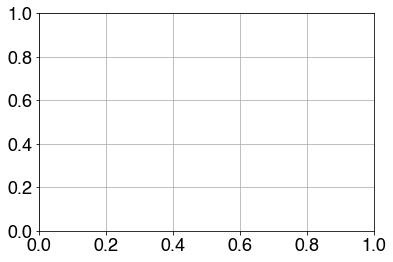

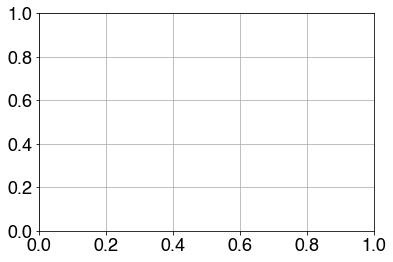

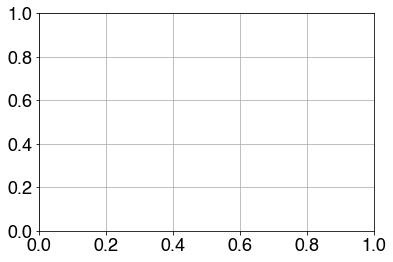

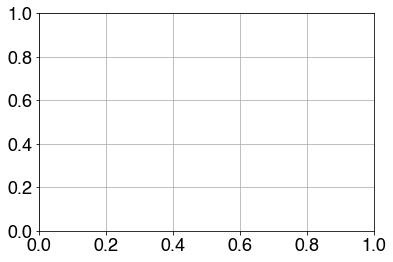

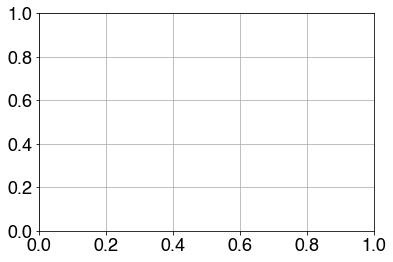

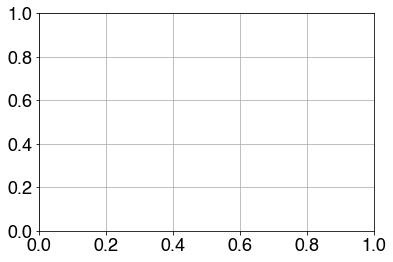

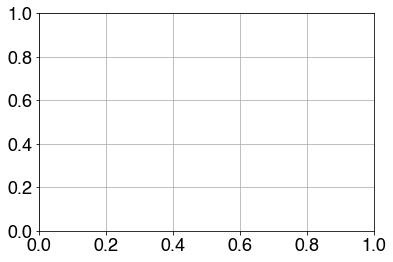

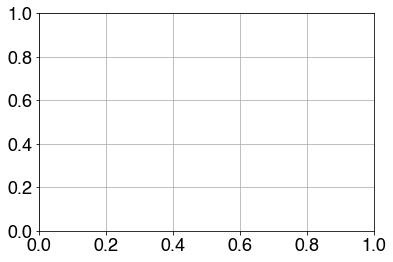

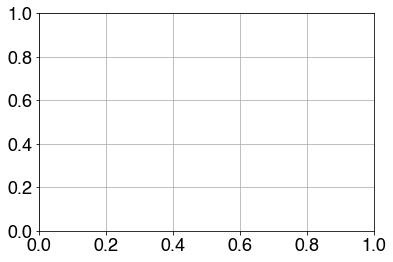

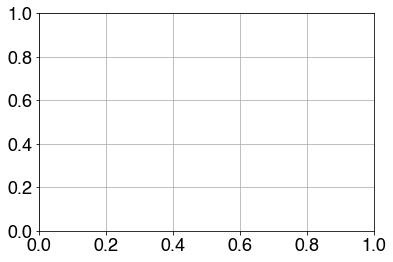

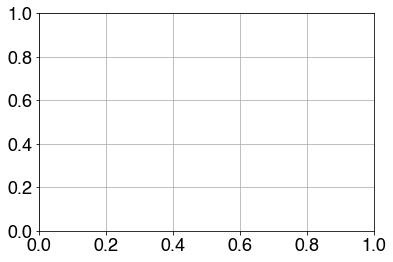

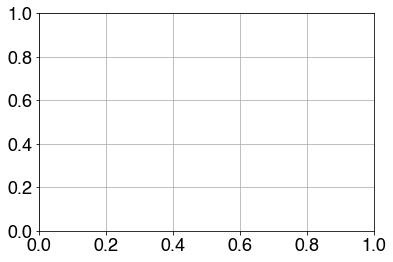

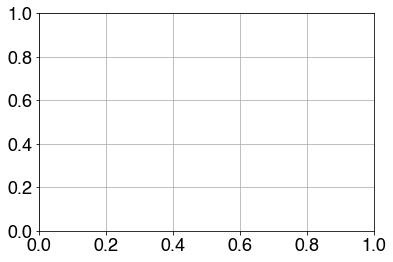

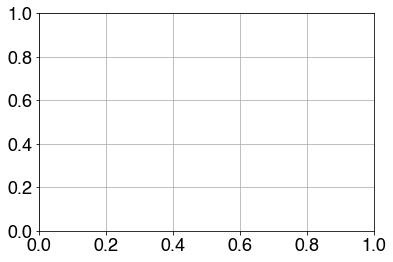

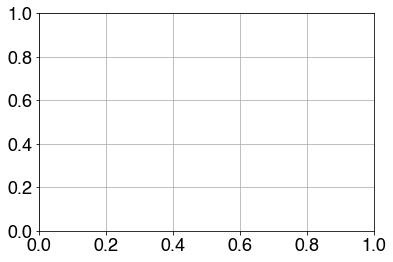

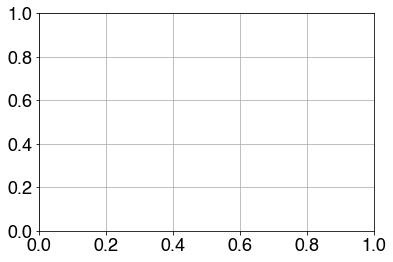

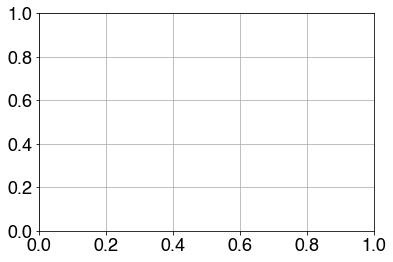

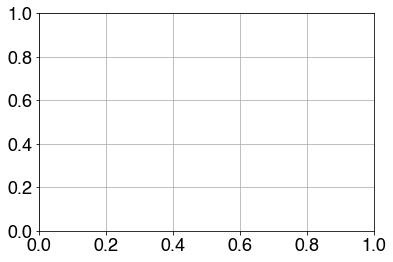

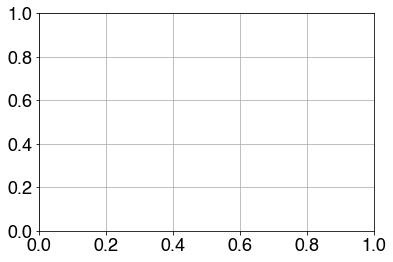

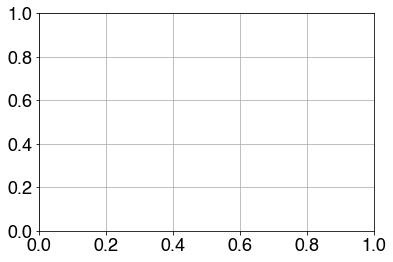

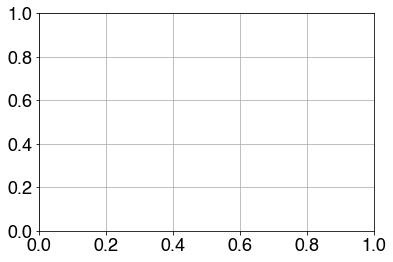

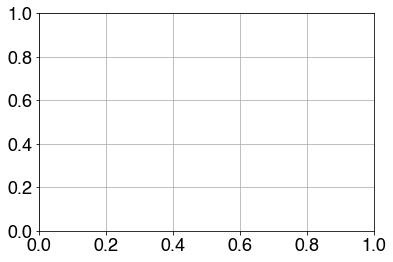

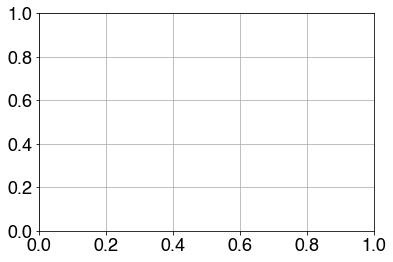

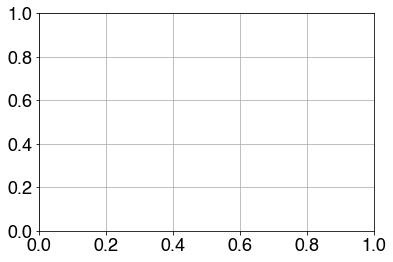

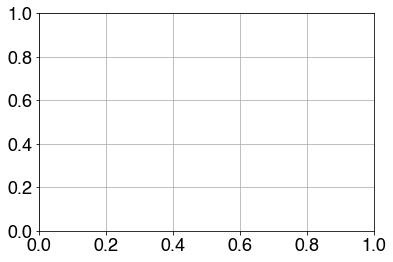

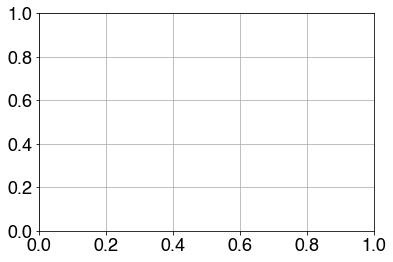

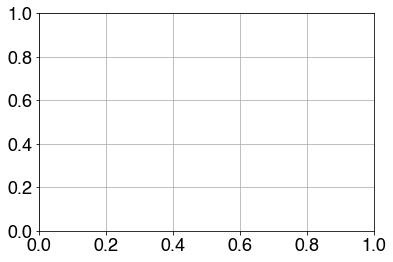

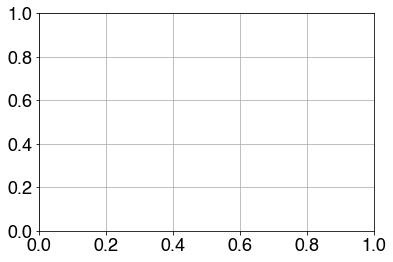

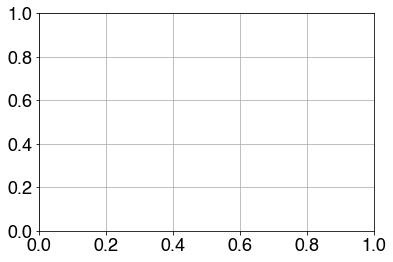

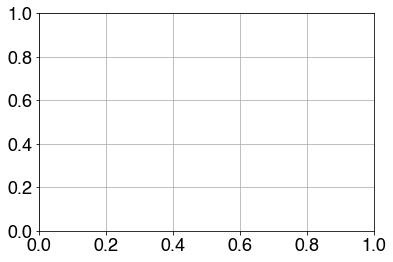

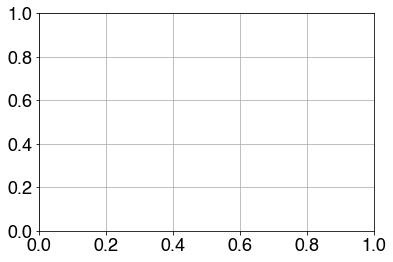

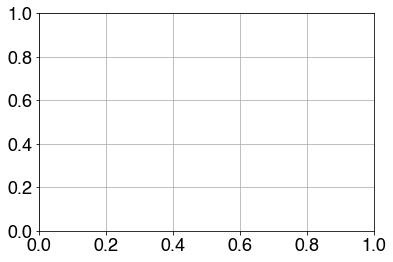

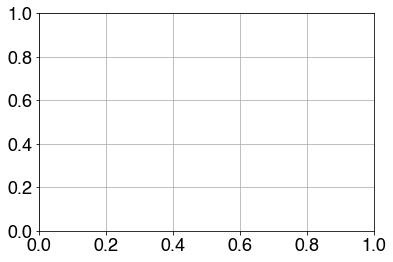

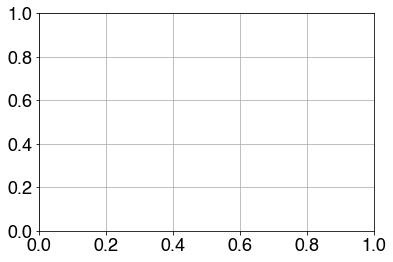

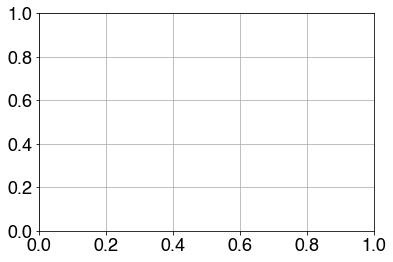

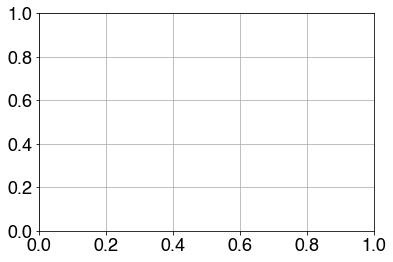

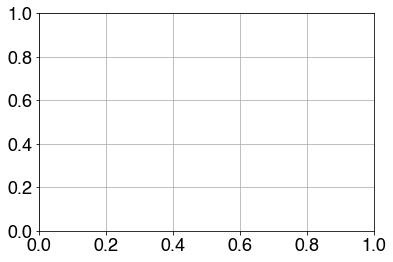

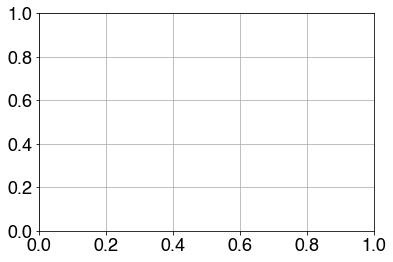

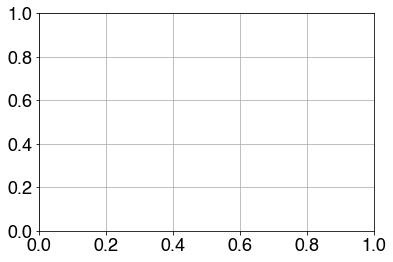

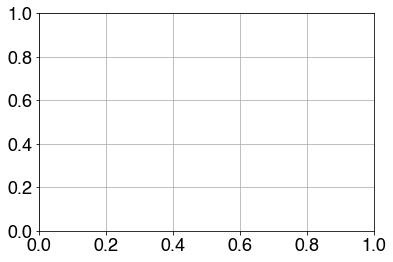

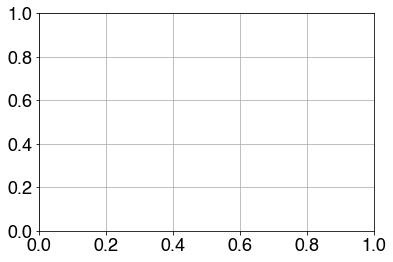

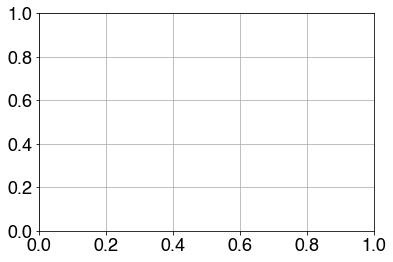

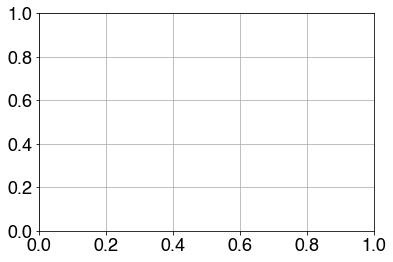

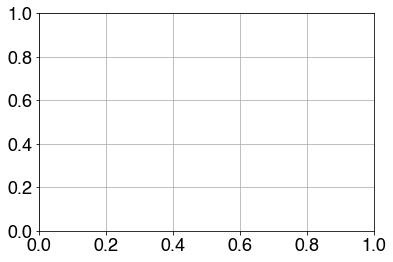

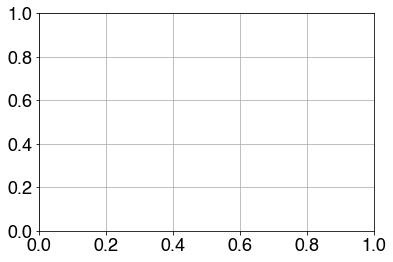

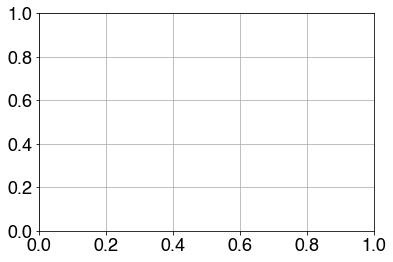

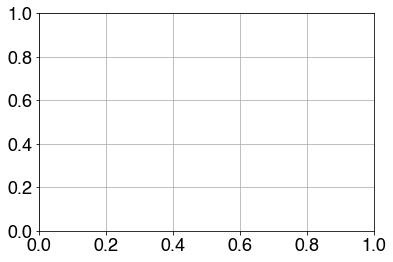

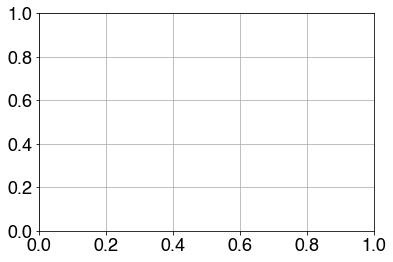

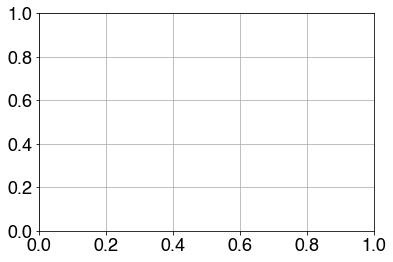

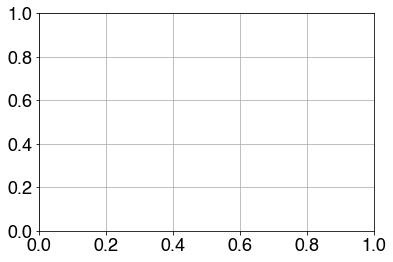

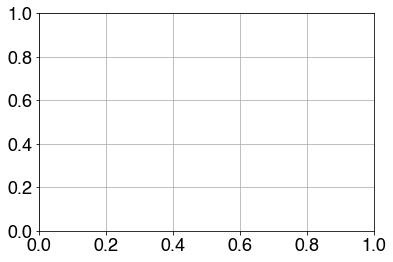

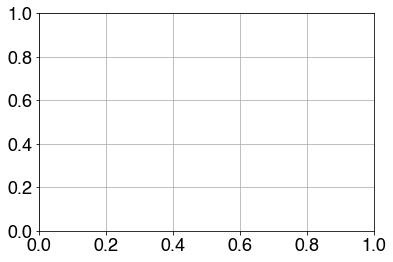

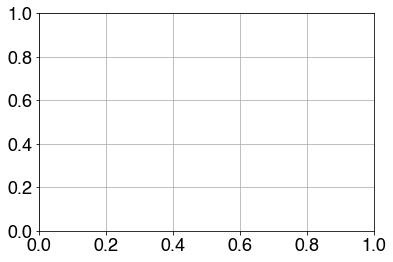

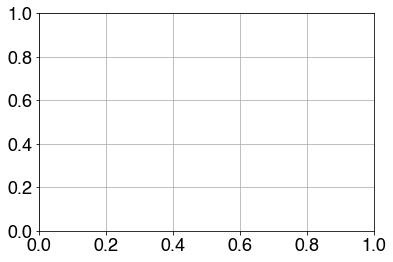

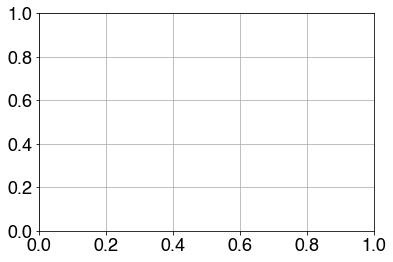

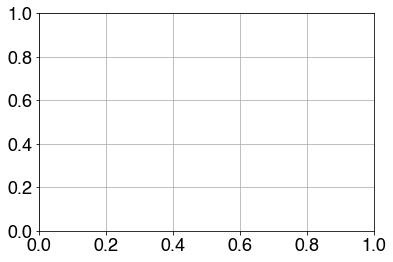

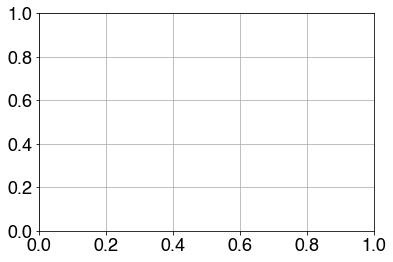

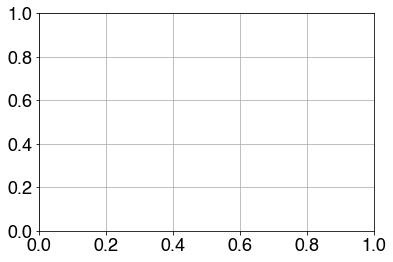

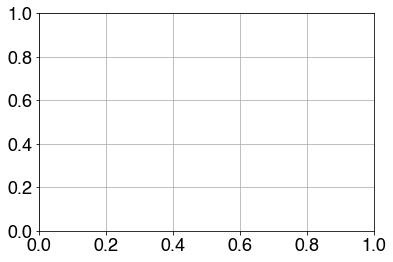

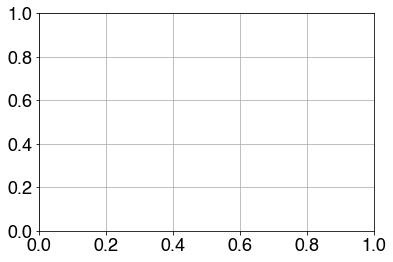

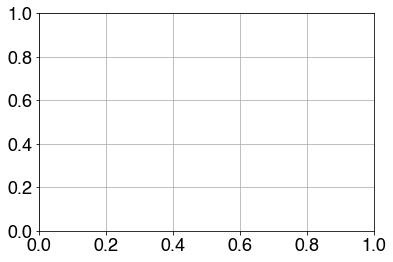

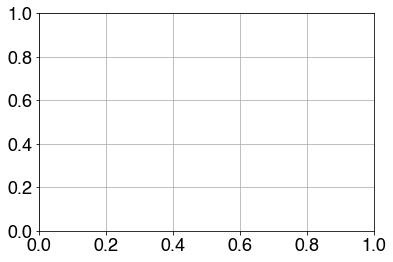

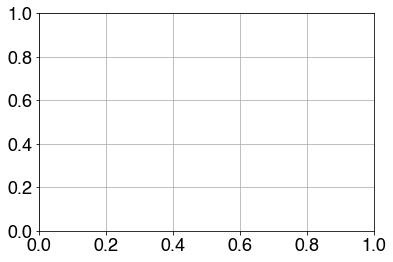

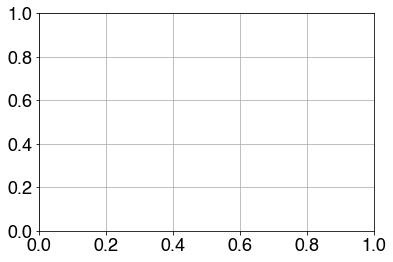

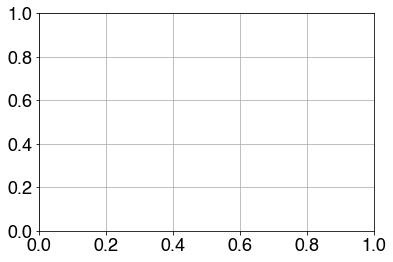

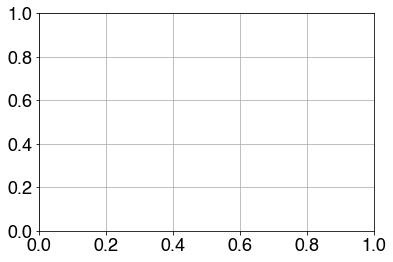

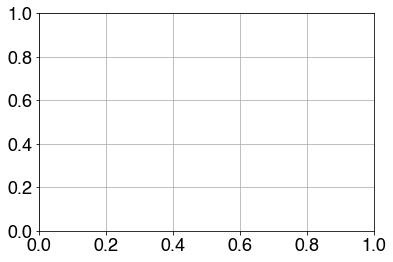

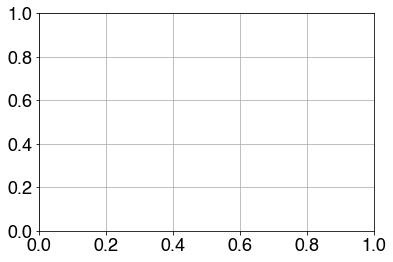

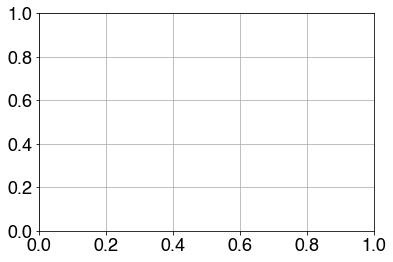

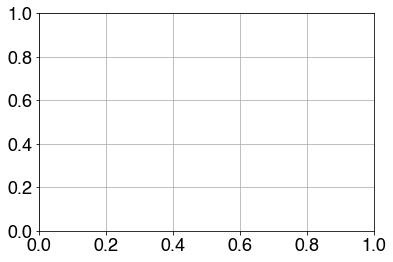

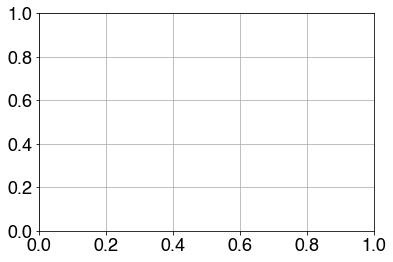

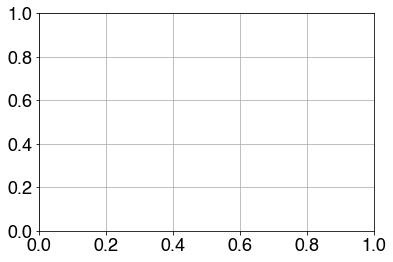

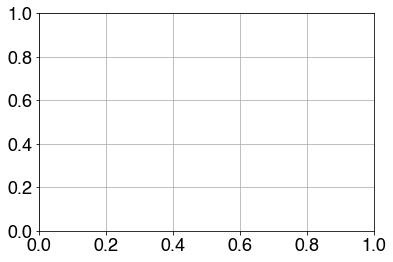

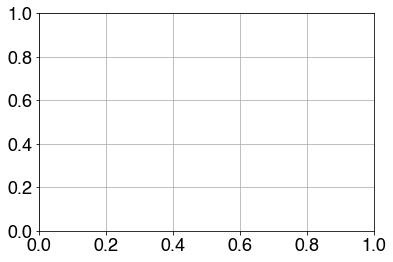

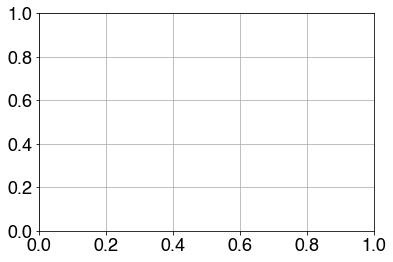

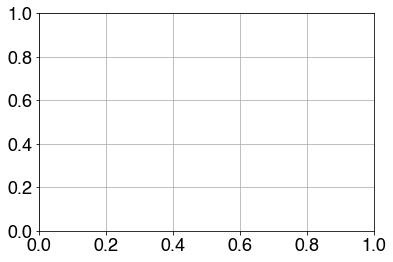

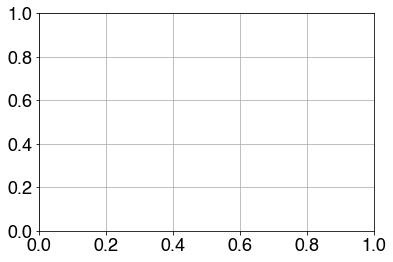

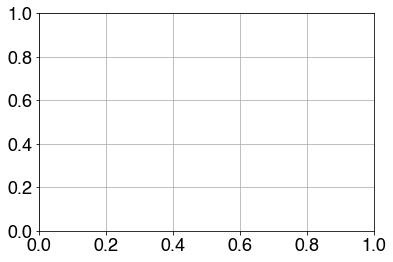

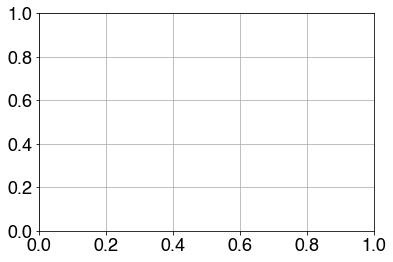

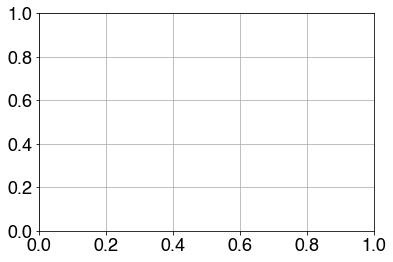

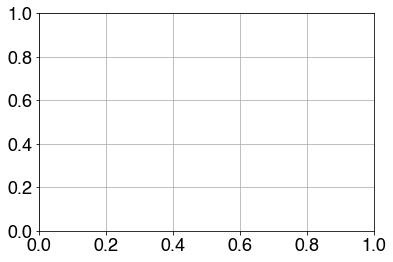

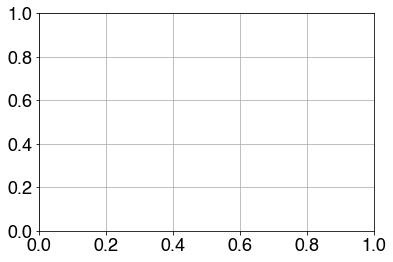

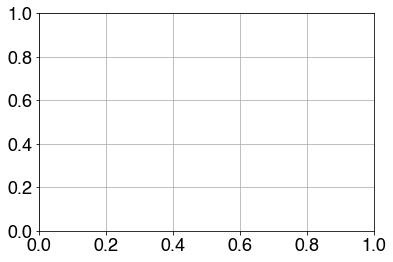

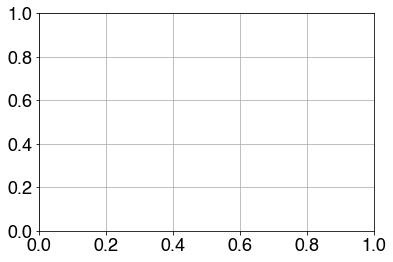

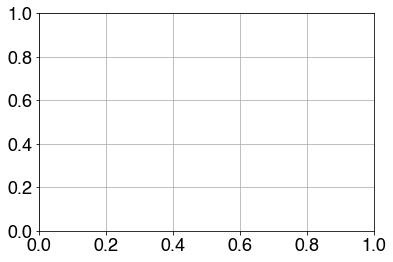

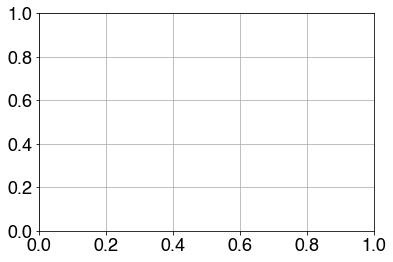

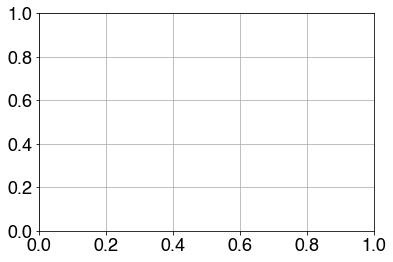

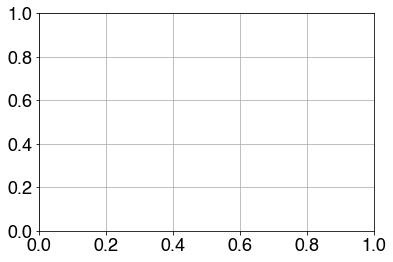

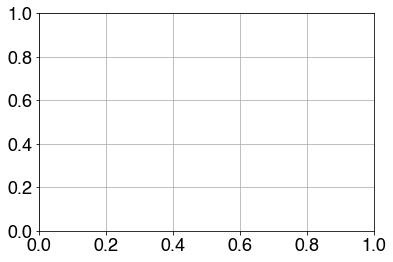

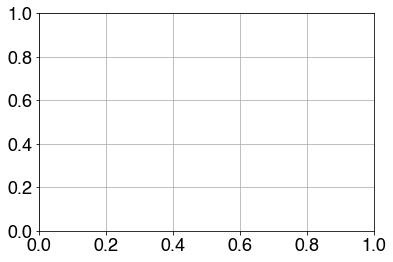

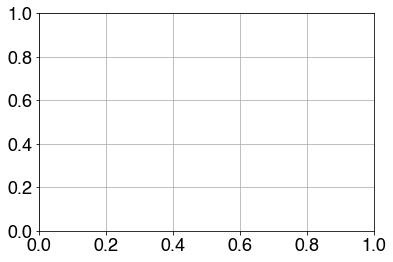

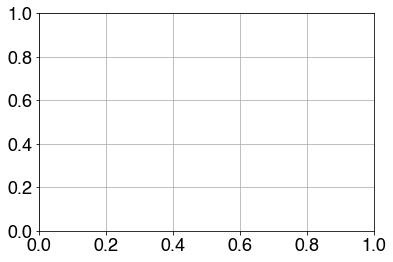

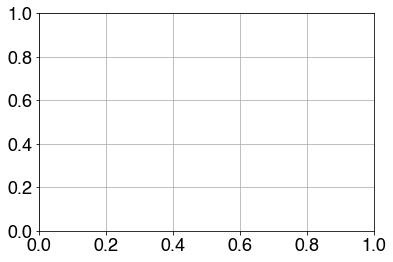

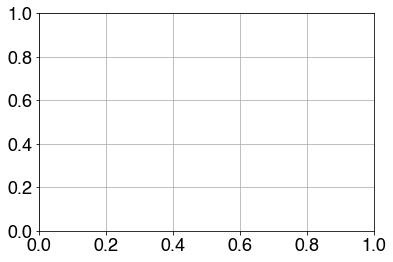

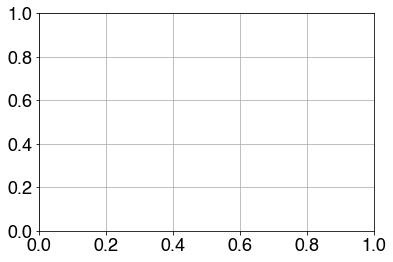

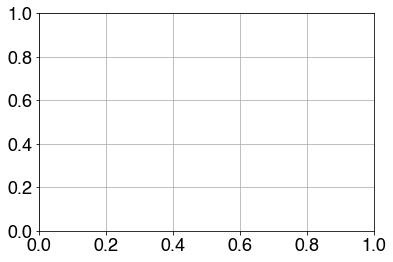

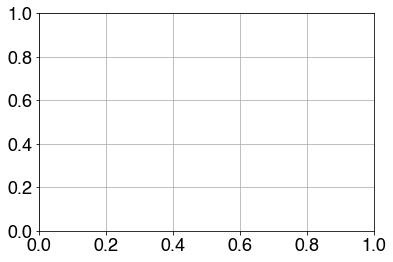

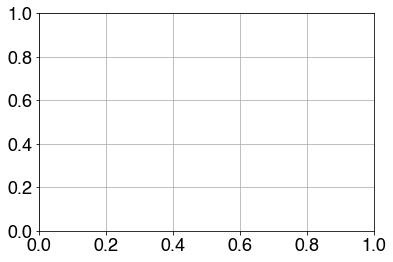

In [76]:
# from celluloid import Camera

# # taken from MATLAB

# # # init array
# # colour_label = np.zeros_like(plot)

# # # set values based on vorticity of fluid
# # colour_label = np.where(plot > 1.002, 1, 0) # 1.002
# # ind_2 = np.where(plot<0.998) # 0.998
# # colour_label[ind_2] = 2

# point_size = 1

# # create figure object
# fig = plt.figure(figsize=(18,12))
# # load axis box
# ax = plt.axes()
# # set axis limit
# ax.set_ylim(np.min(y_traj), np.max(y_traj))
# ax.set_xlim(np.min(x_traj), np.max(x_traj))
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title(f'Particle trajectories over T = {Tend} with timestep {dt}.\n'
#              + f'The velocity domain is defined over x $\in$ [{np.round(x_start, 4)}, {np.round(x_end, 4)}], '
#              + f'y $\in$ [{np.round(y_start, 4)}, {np.round(y_end, 4)}],\n'
#              + f'with {Nx} x gridpoints and {Ny} y gridpoints.')

# # getting colour for each individual particle
# if len(x_pos) > 1:
#     # colour array
#     no_colour = x_traj[0].flatten().shape[0]
#     colour = np.arange(no_colour)
# else:
#     colour = [0]

# # generating gif
# camera = Camera(fig)
# for i in range(0, len(x_traj), 2):
#     ax.scatter(x_traj[i], y_traj[i], cmap='coolwarm', alpha=0.85, c='deepskyblue', s=point_size) #color = ['r', 'm', 'b', 'c', 'k'])
#     plt.grid()
#     plt.pause(0.001)
#     camera.snap()

# # saving gif
# animation = camera.animate()
# animation.save('turbulence_slowwaves.gif', writer='pillow', fps=30)

In [7]:
point_size=1

plt.figure(figsize=(18,14))

plt.scatter(nowave_x_traj[-1].flatten(), nowave_y_traj[-1].flatten(), 
            c='r', alpha=0.75, label = 'no wave flow', s = point_size)
plt.scatter(fastwave_x_traj[-1].flatten(), fastwave_y_traj[-1].flatten(), 
            c='b', alpha=0.75, label = 'fast wave flow', s = point_size)


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

NameError: name 'nowave_x_traj' is not defined

<Figure size 1296x1008 with 0 Axes>

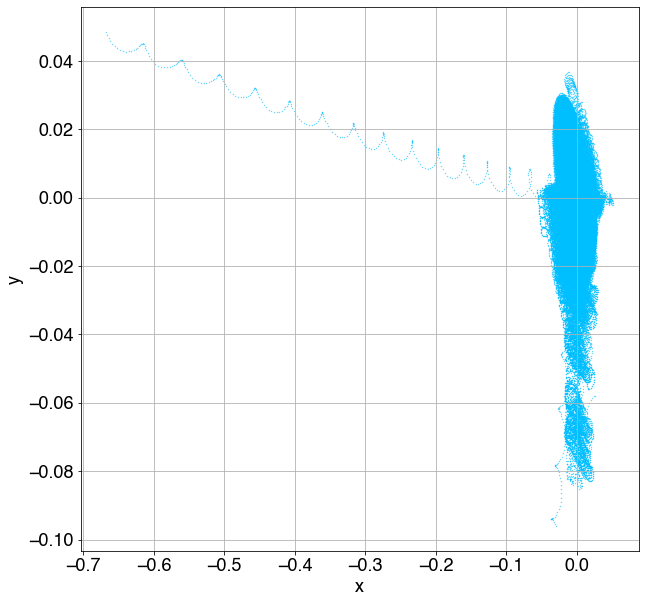

In [43]:
# sum through each position
no_steps = len(fastwave_x_traj)

avg_mat_x = np.zeros_like(fastwave_x_traj)
avg_mat_y = np.zeros_like(fastwave_y_traj)

# loop through each time step
for i in range(no_steps):
    # add difference in particle positions caused by wave perturbation
    avg_mat_x += nowave_x_traj - fastwave_x_traj
    avg_mat_y += nowave_y_traj - fastwave_y_traj
    
# average the sums
avg_mat_x = avg_mat_x/no_steps
avg_mat_y = avg_mat_y/no_steps


point_size = .1

plt.figure(figsize=(10,10))

plt.scatter(avg_mat_x, avg_mat_y, alpha = 0.85, c='deepskyblue', s=point_size)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

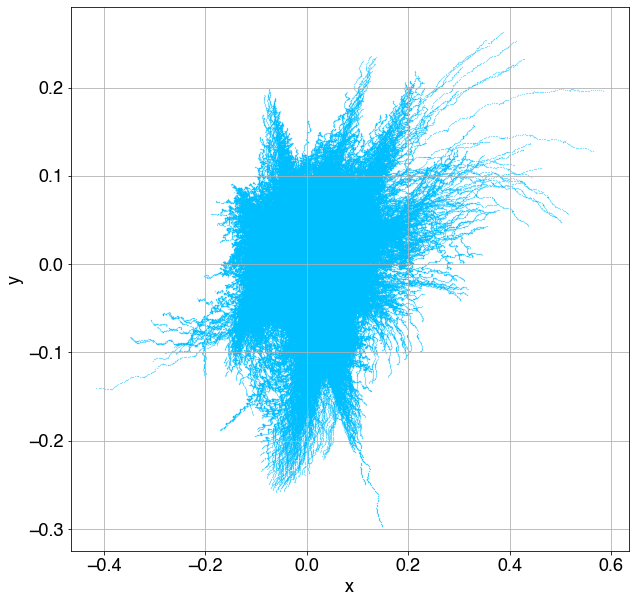

In [55]:
point_size = 0.05

plt.figure(figsize=(10,10))

plt.scatter(avg_mat_x, avg_mat_y, alpha = 0.85, c='deepskyblue', s=point_size)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [56]:
avg_dist = np.sqrt(avg_mat_x**2 + avg_mat_y**2)

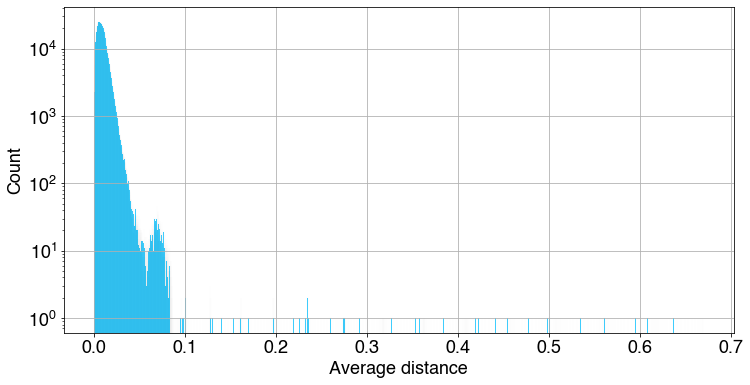

The maximum distance is 0.6696036744914693


In [44]:
avg_dist = np.sqrt(avg_mat_x**2 + avg_mat_y**2)

plt.figure(figsize=(12,6))
g = sns.histplot(avg_dist.flatten(), alpha=0.75, color='deepskyblue')
plt.grid()
plt.xlabel('Average distance')
g.set_yscale('log')
plt.show()

print(f'The maximum distance is {np.max(avg_dist)}')

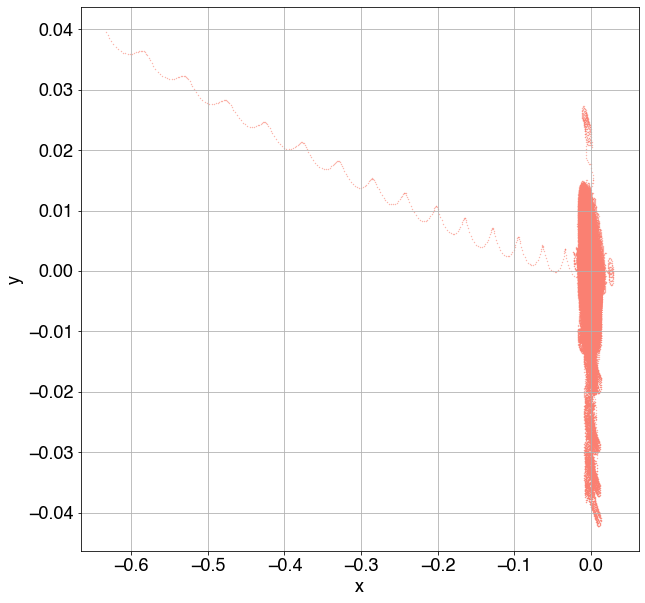

In [45]:
# sum through each position
no_steps = len(nowave_x_traj)

avg_mat_x = np.zeros_like(nowave_x_traj)
avg_mat_y = np.zeros_like(nowave_y_traj)

# loop through each time step
for i in range(no_steps):
    # add difference in particle positions caused by wave perturbation
    avg_mat_x += nowave_x_traj - slowwave_x_traj
    avg_mat_y += nowave_y_traj - slowwave_y_traj
    
# average the sums
avg_mat_x = avg_mat_x/no_steps
avg_mat_y = avg_mat_y/no_steps


point_size = .1

plt.figure(figsize=(10,10))

plt.scatter(avg_mat_x, avg_mat_y, alpha = 0.85, c='salmon', s=point_size)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

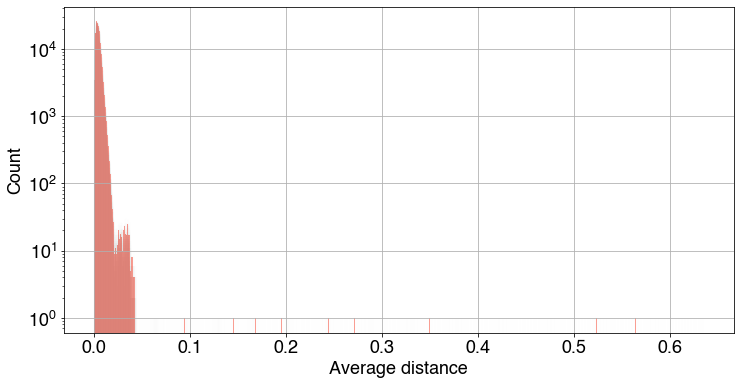

The maximum distance is 0.6340769084117863


In [46]:
avg_dist = np.sqrt(avg_mat_x**2 + avg_mat_y**2)

plt.figure(figsize=(12,6))
g = sns.histplot(avg_dist.flatten(), alpha=0.75, color='salmon')
plt.grid()
plt.xlabel('Average distance')
g.set_yscale('log')
plt.show()

print(f'The maximum distance is {np.max(avg_dist)}')

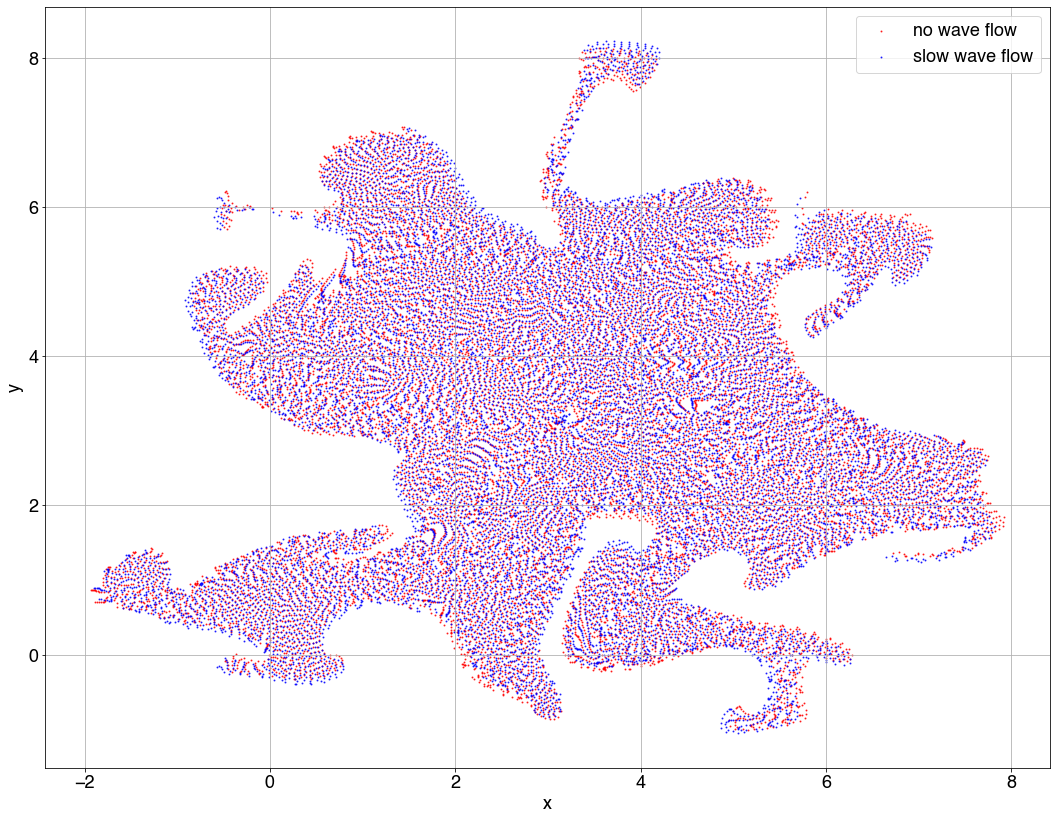

In [81]:
point_size=1

plt.figure(figsize=(18,14))

plt.scatter(nowave_x_traj[-1].flatten(), nowave_y_traj[-1].flatten(), 
            c='r', alpha=0.75, label = 'no wave flow', s = point_size)
plt.scatter(slowwave_x_traj[-1].flatten(), slowwave_y_traj[-1].flatten(), 
            c='b', alpha=0.75, label = 'slow wave flow', s = point_size)


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

---
## benchmarking distance matrix

In [8]:
from numba import jit

# fast distance function
@jit(nopython=True)
def fast_dist_mat(coords, n):
    
    # init distance matrix
    dist_mat = np.zeros((n,n))
    
    for i in range(0,n):
        #for j in range(0,n):
        
        # store current particle position
        current_pos = coords[i, :]
        
        hold = (coords - current_pos)**2
        hold = np.sum(hold, axis=1)
        
        # compute distances from current position to all others
        d = np.sqrt(hold)
        
        # store distance row
        dist_mat[i,:] = d
        
    return dist_mat

# fast distance function
@jit(nopython=True)
def fast_dist_mat2(coords, n):
    
    # init distance matrix
    dist_mat = np.zeros((n,n))
    
    # loop through particles
    for i in range(0,n):
        
        # store current particle position
        current_pos = coords[i, :]
        
        # compute distances from current position to all others
        d = np.sqrt(np.sum(((coords - current_pos)**2), axis=1))
        
        # store distance row
        dist_mat[i,:] = d
        
    return dist_mat

def norm_dist(coords):
    dist_mat = norm(coords[:, None, :] - coords[None, :,  :], axis=2)
    return dist_mat

def c_dist(coords):
    dist_mat = cdist(coords,coords)
    return dist_mat

In [41]:
x_pos.shape

(600, 64, 64)

In [59]:
final_x = x_pos[-1].flatten()
final_y = y_pos[-1].flatten()

n = final_x.shape[0]

coords = np.column_stack((final_x, final_y))

%timeit norm_dist(coords)

%timeit fast_dist_mat(coords,n)

%timeit fast_dist_mat2(coords,n)

%timeit c_dist(coords)

# check outputs are the same
print(np.all(norm_dist(coords) == fast_dist_mat2(coords,n)))
print(np.all(c_dist(coords) == fast_dist_mat2(coords,n)))

635 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
182 ms ± 957 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
181 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.6 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
True
True


## Constructing Q matrix

In [38]:
# move x_traj to x_pos, same for y
x_pos, y_pos = np.array(x_traj), np.array(y_traj)

In [17]:
start = time()

# define variables
r=2
# epsilon = 0.2 # think this is from turbulence
epsilon=0.024

# number of timesteps
no_timestep = x_pos.shape[0]

# number of data points at each time step
m = x_pos[0].flatten().shape[0]

# init empty matrix
Q = np.zeros((m,m))

# distance cutoff
dist_range = np.sqrt(r*epsilon)
print(dist_range)

ident = eye(m)

# loop through each time step
for i in range(no_timestep):
    
    start_inner = time()

    # retrieve data
    x = x_pos[i].flatten() # flatten added
    y = y_pos[i].flatten() # flatten added
    
    # create coordinate array
    coords = column_stack((x, y))

    # get distance matrix
    dist_mat = cdist(coords, coords)

#     # compute using broadcasting
#     dist_mat = norm(coords[:, None, :] - coords[None, :,  :], axis=2)

    # set distances over range to 0
    K = where(dist_mat <= dist_range, dist_mat, 0)

    # square and divide by epsilon
    K = exp(-(K**2)/epsilon)

    # set values of 1 to 0
    K = where(K == 1, 0, K)

    # set diagonal entries to 1
    K += ident

    # compute diffusion map matrix 
    q = 1 / np.sum(K, axis=1)

    p_epsilon = diag(q)@K
    # d_epsilon = 1/np.sum(p_epsilon, axis=0)
    B = np.diag(1/np.sum(p_epsilon, axis=0)) @ p_epsilon.T @ p_epsilon

    Q += B
    
    end_inner = time()
    
    print(f'Time for loop {i}: {end_inner - start_inner}')

# normalize
Q = Q/len(x_pos)
    
end = time()


print(f'Time taken to compute the Q matrix is {end-start}')

0.21908902300206645
Time for loop 0: 3.7449288368225098


KeyboardInterrupt: 

In [14]:
# np.save('Q_mat_64x64_result4', Q)

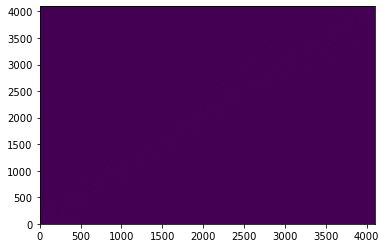

In [104]:
plt.pcolor(Q)

## Percentage Sparsity
choose the values for $\varepsilon$ such that the sparse matrix has around 1% to 5% populated entries.

In [10]:
percent_sparse = len(np.where(Q.flatten() != 0)[0]) / Q.flatten().shape[0]*100
percent_sparse

32.93588161468506

In [11]:
# compute 
L = 1/epsilon * (Q - np.eye(Q.shape[0]))

# compute eigenvalues
vals, vecs = np.linalg.eig(L)

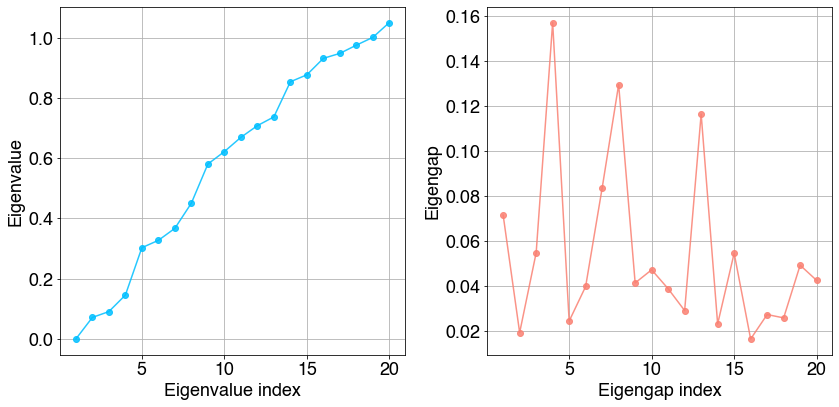

In [12]:
vals_sort = np.sort(abs(vals))

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(np.arange(vals.shape[0])[:20] + 1, vals_sort[:20], '-o', c='deepskyblue',
         alpha=0.85)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
# plt.title('The first 20 eigenvalues of the matrix $L_{\epsilon}$')
plt.grid()

plt.subplot(122)
#plt.figure(figsize=(12,8))
plt.plot(np.arange(vals.shape[0])[:20] + 1, np.diff(vals_sort)[:20], '-o', c='salmon',
         alpha=0.85)
plt.xlabel('Eigengap index')
plt.ylabel('Eigengap')
# plt.title('The first 20 eigenvalues of the matrix $L_{\epsilon}$')
plt.grid()
plt.tight_layout()
plt.show()

In [94]:
vals, vecs = np.linalg.eig(Q)

---
## Using Q as affinity matrix
This actually appears to work for 3/4 clusters but not for 2. I believe this is because the mehtod requires noise/non-coherent regions to be included as an additional cluster.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


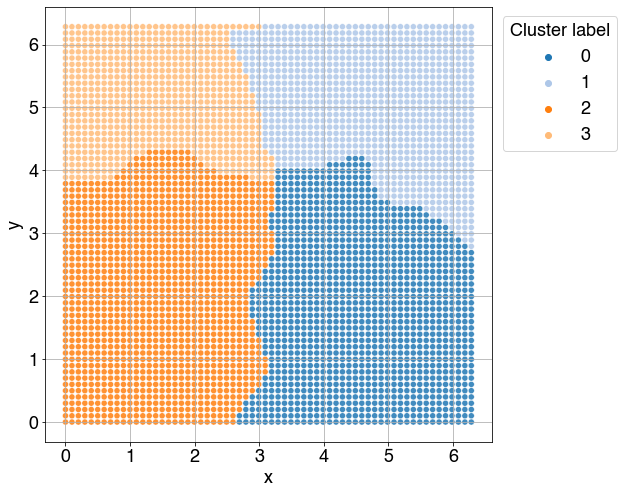

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


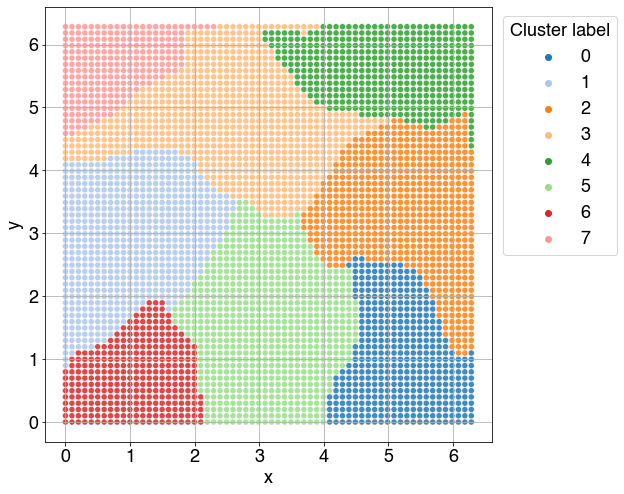

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


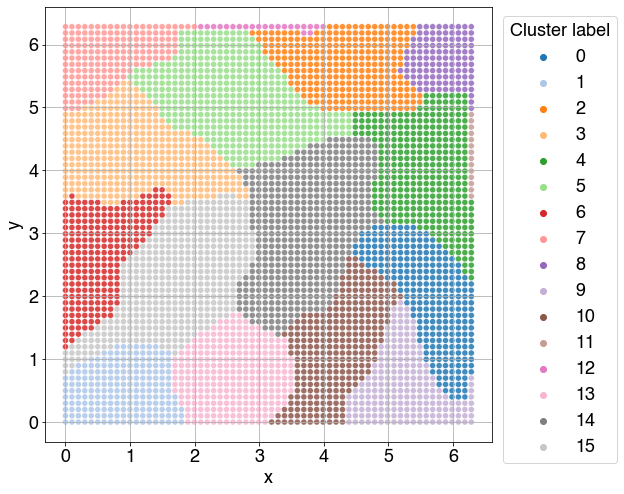

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


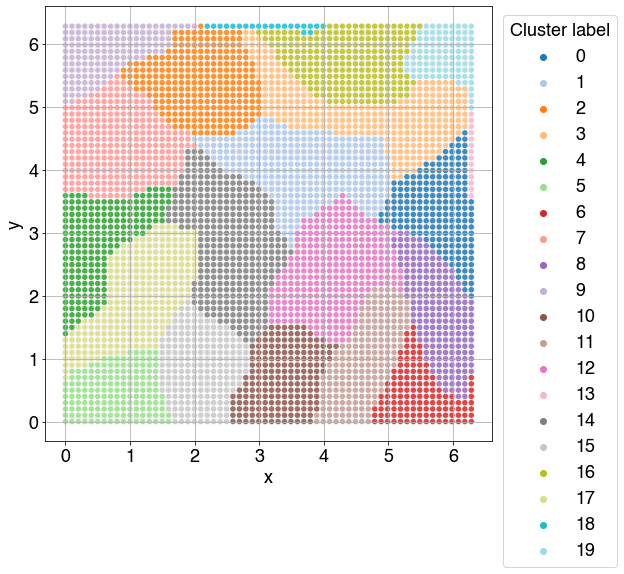

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


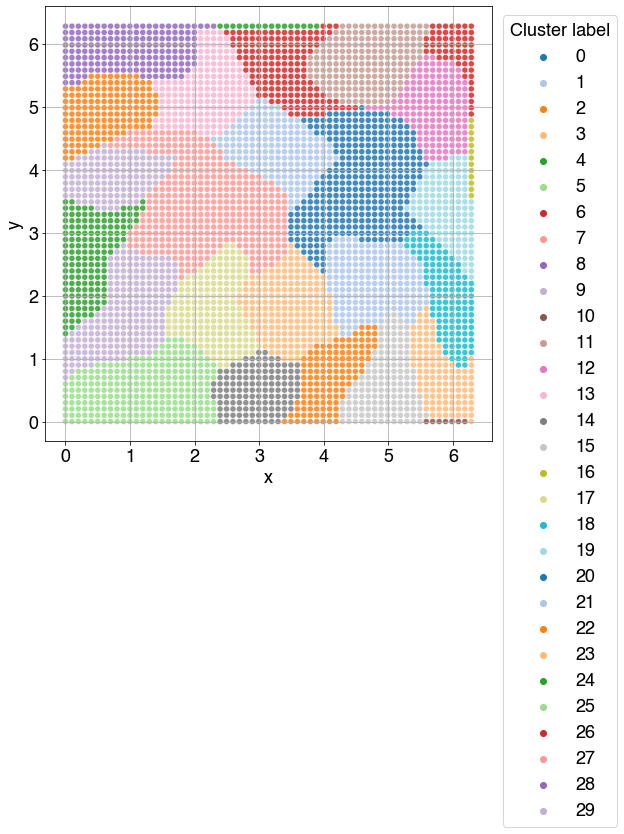

In [16]:
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

no_clust = 4

clust_list = [2,3,4,5,6,7,8,9,10,11,12,13]
clust_list = [4,8,16,20,30]

sil_dict = {}

for no_clust in clust_list:


    legend_lab = np.arange(no_clust) + 1

    # fit spectral clustering
    sc = SpectralClustering(no_clust, affinity='precomputed').fit(Q)

    # plot initial position with labels
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=x_pos[0].flatten(),
                    y=y_pos[0].flatten(),
                    hue=sc.labels_,
                    palette = 'tab20', 
                    alpha = 0.85)

    # plt.title(f'Clustering Result for {no_clust} clusters')
    plt.legend(title='Cluster label', bbox_to_anchor=(1.005,1))
    # plt.legend(legend_lab, title='Cluster label', bbox_to_anchor=(1.005,1))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.show()

    silhouette_avg = silhouette_score(Q, sc.labels_)
    sample_silhouette_values = silhouette_samples(Q, sc.labels_)
    
    sil_dict[no_clust] = silhouette_avg

    

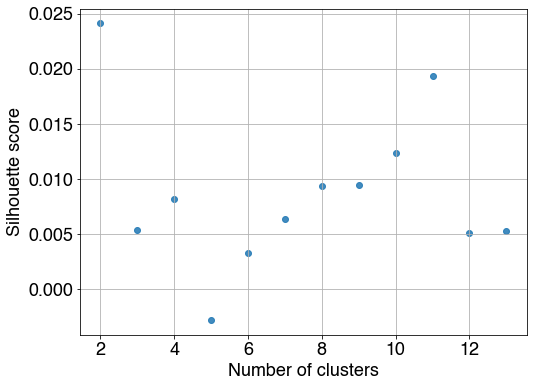

In [40]:
plt.figure(figsize=(8,6))
plt.scatter(sil_dict.keys(), sil_dict.values(), alpha=0.85)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

In [58]:
sil_dict.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10])